In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mdtraj as md
import sys
import os
import cgmap
from glob import glob

sns.set_context("talk")
style=plt.style.available[-3]
print(style)
plt.style.use(style)

seaborn-white


# Setup

### In the following cell, we define and load all the relevant functions required to load the trajectory and run the calculations of interest

In [2]:
def load_trj(topfile,coordfile):
    if coordfile=="":
        trj = md.load(topfile)
        for a in trj.top.atoms: a.mass = a.element.mass 
        for a in trj.top.atoms: a.charge = 0
        prefix=os.path.splitext(topfile)[0]
    else:
        trj = md.load(coordfile, top=topfile)
        for a in trj.top.atoms: a.mass = a.element.mass # computing the masses of each atom
        for a in trj.top.atoms: a.charge = 0 # setting all charges to neutral
        prefix=os.path.splitext(coordfile)[0]
    return trj, prefix

def mammalian_arp23_four_site(arp2_name="'ARP2'",arp3_name="'ARP3'"):
    arp2_string_list = ["%s and (residue 7 to 33 or residue 74 to 150 or residue 352 to 387)",
                       "%s and (residue 34 to 38 or residue 55 to 73)",
                       "%s and (residue 151 to 185 or residue 277 to 326 or residue 339 to 351)",
                       "%s and (residue 186 to 265)",
                       "%s"]

    arp3_string_list = ["%s and (residue 6 to 32 or residue 78 to 153 or residue 375 to 408)",
                       "%s and (residue 33 to 37 or residue 60 to 77)",
                       "%s and (residue 154 to 196 or residue 295 to 344 or residue 362 to 374)",
                       "%s and (residue 197 to 282)",
                       "%s"
                       ]

    # Note the arp3 selection does not contain the dloop!
    monomer_list = [1]

    bead_string_list = [ bead_string%("segment_id %s"%arp2_name) \
                             for bead_string in arp2_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp2_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    bead_string_list = [ bead_string%("segment_id %s"%arp3_name) \
                             for bead_string in arp3_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp3_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    return arp2_results, arp3_results

def mammalian_arp23_two_site(arp2_name="'ARP2'",arp3_name="'ARP3'"):
    arp2_string_list = ["%s and (residue 151 to 185 or residue 277 to 326 or residue 339 to 351)",
                       "%s and (residue 186 to 265)"]

    arp3_string_list = ["%s and (residue 154 to 196 or residue 295 to 344 or residue 362 to 374)",
                       "%s and (residue 197 to 282)"]

    # Note the arp3 selection does not contain the dloop!
    monomer_list = [1]

    bead_string_list = [ bead_string%("segment_id %s"%arp2_name) \
                             for bead_string in arp2_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp2_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    bead_string_list = [ bead_string%("segment_id %s"%arp3_name) \
                             for bead_string in arp3_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp3_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    return arp2_results, arp3_results

def get_angle_dist_arp23(trj):
    selstring="and (name 'CA' or name 'CB')"

    arp23_results_list = mammalian_arp23_four_site()
    arp23_dist_dihed = []
    com_positions = []
    for subunit_info in arp23_results_list:
        sel_list,label_list, resSeq_list, segment_id_list, chain_list = subunit_info
        trj_cg = cgmap.cg_by_selection(trj,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
        dihedral_map = ( md.compute_dihedrals(trj_cg, ((1,0,2,3),),periodic=True) )
        dihed_trj = np.degrees(dihedral_map.mean(axis=1))
        dist_map = ( md.compute_distances(trj_cg, ((1,3),),periodic=True) )
        dist_trj = dist_map.mean(axis=1)
        arp23_dist_dihed.append((dist_trj,dihed_trj))

    arp2_dist = arp23_dist_dihed[0][0]
    arp2_dihed = arp23_dist_dihed[0][1]
    arp3_dist = arp23_dist_dihed[1][0]
    arp3_dihed = arp23_dist_dihed[1][1]

    return arp2_dist, arp2_dihed, arp3_dist, arp3_dihed

def get_com_dist_arp23(trj):
    selstring="and (name 'CA' or name 'CB')"

    arp23_results_list = mammalian_arp23_two_site()
    arp23_dist_dihed = []
    com_positions = []
    for subunit_info in arp23_results_list:
        sel_list,label_list, resSeq_list, segment_id_list, chain_list = subunit_info
        trj_cg = cgmap.cg_by_selection(trj,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
        com_positions.append(md.compute_center_of_mass(trj_cg))

    com_array = np.array(com_positions)
    dr = com_array[0]-com_array[1]
    arp2_arp3_dist = np.sqrt( (dr*dr).sum(axis=-1) )
    
    return arp2_arp3_dist

def get_residue_distance(trj,segname, res1,res2,atom1="CA",atom2="CA"):
    atom1 = trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname,res1,atom1))[0]
    atom2 = trj.top.select("segname '%s' and residue %i \
                               and name %s"%(segname,res2,atom2))[0]
    distances = md.compute_distances(trj,((atom1,atom2),),periodic=True)
    return distances[:,0]

def get_residue_dist_angle_dihedral(trj,segname_list, residue_list, atom_name_list=None):
    atom_list = []
    for i in range(len(segname_list)):
        if atom_name_list is None:
            atom_name = "CA"
        else:
            atom_name = atom_name_list[i]

        atom_list.append(
            trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname_list[i],residue_list[i],atom_name))[0]
        )

    if len(segname_list) == 4:
        dihedrals = np.degrees(
            md.compute_dihedrals(trj,(atom_list,),periodic=True)
        )
        return dihedrals[:,0]
    elif len(segname_list) == 3:
        angles = np.degrees(
            md.compute_angles(trj,(atom_list,),periodic=True)
        )
        return angles[:,0]
    elif len(segname_list) == 2:
        distances = md.compute_distances(trj,(atom_list,),periodic=True)
        return distances[:,0]
    else:
        return None

def get_residue_distance(trj,segname, res1,res2,atom1='CA',atom2='CA'):
    atom1 = trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname,res1,atom1))[0]
    atom2 = trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname,res2,atom2))[0]
    distances = md.compute_distances(trj,((atom1,atom2),),periodic=True)
    return distances[:,0]

# Other distances
def other_distances(trj):
    d2_116_187 = get_residue_distance(trj, 'ARP2', 116, 187)
    d2_72_211 = get_residue_distance(trj,'ARP2',72,211)
    d3_119_198 = get_residue_distance(trj,'ARP3',119,198)
    d3_76_222 = get_residue_distance(trj,'ARP3',76,222)
    return d2_116_187, d2_72_211, d3_119_198, d3_76_222

# Clamp twisting
def clamp_twisting_OLD(trj):
    clamp_dihedral = get_residue_dist_angle_dihedral(trj,("RPC4","RPC4","RPC2","RPC2"), (32,147,244,18))
    return clamp_dihedral

def clamp_twisting_NEW(trj):
    clamp_dihedral = get_residue_dist_angle_dihedral(trj,("RPC4","RPC4","RPC4","ARP3"), (32,147,157,93))
    return clamp_dihedral


# Helix bending
def helix_bending(trj):
    helix_bending = get_residue_dist_angle_dihedral(trj,("RPC4","RPC4","RPC4"), (166,143,130))
    return helix_bending

# Movement of C-term groove
def c_term_groove(trj):
    d2_152_387 = get_residue_distance(trj,'ARP2',152,387)
    d3_163_409 = get_residue_distance(trj,'ARP3',163,409)
    return d2_152_387, d3_163_409

# Opening of BEG, W-loop uncurling
def BEG_Wloop(trj):
    # BEG1
    d2_173_140 = get_residue_distance(trj,'ARP2',173,140)
    d2_173_371 = get_residue_distance(trj,'ARP2',173,371)

    # BEG2
    d3_184_143 = get_residue_distance(trj,'ARP3',184,143)
    d3_184_393 = get_residue_distance(trj,'ARP3',184,393)
    return d2_173_140, d2_173_371, d3_184_143, d3_184_393

def cleft_opening_closing(trj):
    # Arp2
    d2_15_162 = get_residue_distance(trj,'ARP2',15,162)
    d2_16_161 = get_residue_distance(trj,'ARP2',16,161)
    d2_62_211 = get_residue_distance(trj,'ARP2',62,211)

    # Arp3
    d3_14_173 = get_residue_distance(trj,'ARP3',14,173)
    d3_15_172 = get_residue_distance(trj,'ARP3',15,172)
    d3_67_222 = get_residue_distance(trj,'ARP3',67,222)

    return d2_15_162, d2_16_161, d2_62_211, d3_14_173, d3_15_172, d3_67_222

### In the cell below, we load all the relevant trajectory data

### 1) The full junction trajectory, 109 frames

### 2) Arp2/3+mother filament (no daughter, ATP bound state) trajectory, 101 frames

### 3) Shortpitch Arp2/3 complex (ATP bound state) trajectory, 109 frames

### 4) Splayed Arp2/3 complex trajectory, 104 frames

### Will also load in the following PDBs

### $\cdot$ Shortpitch (Active) PDB

### $\cdot$ Splayed (Inactive) PDB

### We will also load in a "morph" trajectory consisting of 31 snapshots of configurations starting from the shortpitch to splayed state

In [3]:
%%time
# Inactive pdb #
topfile="BtArp23_splay/BtArp23_splay_seglabel.pdb"
coordfile=""
inactive_pdb, inactive_pdb_label=load_trj(topfile,coordfile)

# Active pdb #
topfile="7TPT/7TPT_seglabel.pdb"
coordfile=""
active_pdb, active_pdb_label=load_trj(topfile,coordfile)

# morph #
topfile="morph/4jd2_to_branch_morph_seglabels.pdb"
coordfile=""
morph, morph_label = load_trj(topfile,coordfile)

# full junction #
topfile="full_junction/mammalian_junction_full_c27_ionized.nowater.psf"
coordfile="full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.xtc"
full, full_label = load_trj(topfile,coordfile)

# no daughter #
topfile="no_daughter/mammalian_junction_nodaughter_ATP_c27_ionized.nowater.psf"
coordfile="no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.xtc"
nodaughter, nodaughter_label = load_trj(topfile,coordfile)

# complex alone #
topfile="just_complex/mammalian_junction_justcomplex_ATP_c27_ionized_shift.nowater.psf"
coordfile="just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.xtc"
justcomplex, justcomplex_label = load_trj(topfile,coordfile)

# complex alone #
topfile="splayed/mammalian_justcomplex_splayed_ATP_c27_ionized_shift.nowater.psf"
coordfile="splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.xtc"
splayed, splayed_label = load_trj(topfile,coordfile)


/home/ys3382/miniconda3/envs/py365/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:198: RuntimeWarning: divide by zero encountered in true_divide
  particle_density = traj.top.n_atoms / traj.unitcell_volumes[0]
/home/ys3382/miniconda3/envs/py365/lib/python3.7/site-packages/mdtraj/formats/pdb/pdbfile.py:202: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  'cell vectors.', category=UserWarning)


CPU times: user 27.1 s, sys: 895 ms, total: 28 s
Wall time: 28.2 s


# Coarse-grained Quantities

In [4]:
def mammalian_arp23_four_site(arp2_name="'ARP2'",arp3_name="'ARP3'"):
    arp2_string_list = ["%s and (residue 7 to 33 or residue 74 to 150 or residue 352 to 387)",
                       "%s and (residue 34 to 38 or residue 55 to 73)",
                       "%s and (residue 151 to 185 or residue 277 to 326 or residue 339 to 351)",
                       "%s and (residue 186 to 265)",
                       "%s"]

    arp3_string_list = ["%s and (residue 6 to 32 or residue 78 to 153 or residue 375 to 408)",
                       "%s and (residue 33 to 37 or residue 60 to 77)",
                       "%s and (residue 154 to 196 or residue 295 to 344 or residue 362 to 374)",
                       "%s and (residue 197 to 282)",
                       "%s"
                       ]

    # Note the arp3 selection does not contain the dloop!
    monomer_list = [1]

    bead_string_list = [ bead_string%("segment_id %s"%arp2_name) \
                             for bead_string in arp2_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp2_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    bead_string_list = [ bead_string%("segment_id %s"%arp3_name) \
                             for bead_string in arp3_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp3_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    return arp2_results, arp3_results

def mammalian_arp23_two_site(arp2_name="'ARP2'",arp3_name="'ARP3'"):
    arp2_string_list = ["%s and (residue 151 to 185 or residue 277 to 326 or residue 339 to 351)",
                       "%s and (residue 186 to 265)"]

    arp3_string_list = ["%s and (residue 154 to 196 or residue 295 to 344 or residue 362 to 374)",
                       "%s and (residue 197 to 282)"]

    # Note the arp3 selection does not contain the dloop!
    monomer_list = [1]

    bead_string_list = [ bead_string%("segment_id %s"%arp2_name) \
                             for bead_string in arp2_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp2_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    bead_string_list = [ bead_string%("segment_id %s"%arp3_name) \
                             for bead_string in arp3_string_list ]
    selection_string_list = [s for i in monomer_list for s in bead_string_list ]
    label_list = ['C%i'%(j+1) for i in monomer_list for j in range(len(bead_string_list)) ]
    resSeq_list = [len(bead_string_list)*i+j+1 for i in range(len(monomer_list)) for j in range(len(bead_string_list)) ]
    segment_id_list = ["A%i"%i for i in monomer_list for s in bead_string_list ]
    chain_list = [i for i in monomer_list for s in bead_string_list ]
    arp3_results = (selection_string_list, label_list, resSeq_list, segment_id_list, chain_list)

    return arp2_results, arp3_results

def get_angle_dist_arp23(trj):
    selstring="and (name 'CA' or name 'CB')"

    arp23_results_list = mammalian_arp23_four_site()
    arp23_dist_dihed = []
    com_positions = []
    for subunit_info in arp23_results_list:
        sel_list,label_list, resSeq_list, segment_id_list, chain_list = subunit_info
        trj_cg = cgmap.cg_by_selection(trj,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
        dihedral_map = ( md.compute_dihedrals(trj_cg, ((1,0,2,3),),periodic=True) )
        dihed_trj = np.degrees(dihedral_map.mean(axis=1))
        dist_map = ( md.compute_distances(trj_cg, ((1,3),),periodic=True) )
        dist_trj = dist_map.mean(axis=1)
        arp23_dist_dihed.append((dist_trj,dihed_trj))

    arp2_dist = arp23_dist_dihed[0][0]
    arp2_dihed = arp23_dist_dihed[0][1]
    arp3_dist = arp23_dist_dihed[1][0]
    arp3_dihed = arp23_dist_dihed[1][1]

    return arp2_dist, arp2_dihed, arp3_dist, arp3_dihed

# new definition for com distance #
def get_com_dist_arp23(trj):
    selstring="and (name 'CA' or name 'CB')"

    arp23_results_list = mammalian_arp23_two_site()
    arp23_dist_dihed = []
    com_positions = []
    for subunit_info in arp23_results_list:
        sel_list,label_list, resSeq_list, segment_id_list, chain_list = subunit_info
        trj_cg = cgmap.cg_by_selection(trj,sel_list, bead_label_list=label_list, resSeq_list=resSeq_list, segment_id_list=segment_id_list )
        com_positions.append(md.compute_center_of_mass(trj_cg))

    com_array = np.array(com_positions)
    dr = com_array[0]-com_array[1]
    arp2_arp3_dist = np.sqrt( (dr*dr).sum(axis=-1) )
    
    return arp2_arp3_dist

### Run the calculation on the morph trajectory

In [5]:
trj=morph
prefix=morph_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

morph/4jd2_to_branch_morph_seglabels.cg_quantities.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


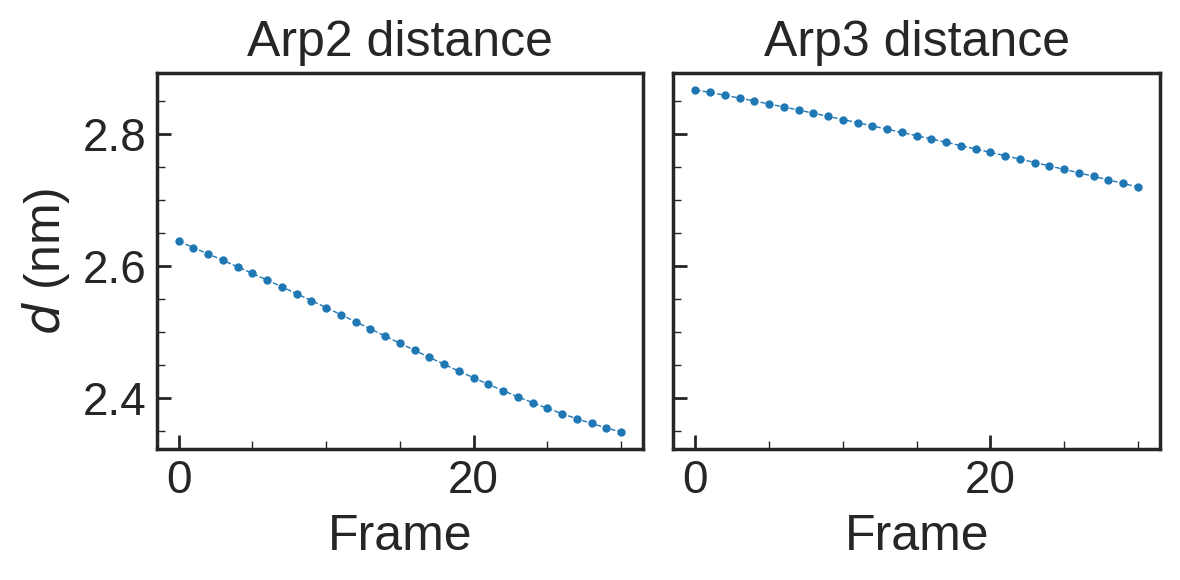

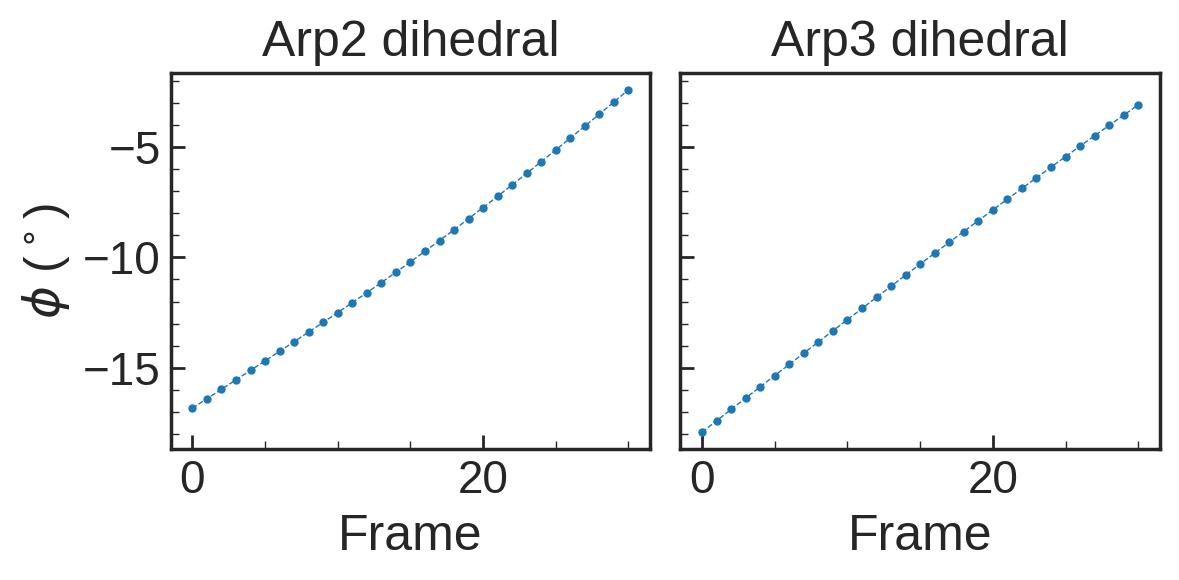

In [6]:
# for plotting, can directly load the output and choose what to plot by specifiying the index: 0,1,2,3,4#
# 0: ARP2 distance, 1: ARP2 dihedral, 2: ARP3 distance, 3: ARP3 dihedral, 4: ARP2-ARP3 com distance
morph_cg=np.loadtxt("morph/4jd2_to_branch_morph_seglabels.cg_quantities.txt")

i=0 # the index value
fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

ax[0].set_title("Arp2 distance")
ax[0].plot(morph_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("$d$ (nm)")

ax[0].legend(loc="upper left",ncol=1, frameon=False,fontsize=9)

i=2 # the index value
ax[1].set_title("Arp3 distance")
ax[1].plot(morph_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")
plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_distance_cg.png", dpi=200)

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=1 # the index value
ax[0].set_title("Arp2 dihedral")
ax[0].plot(morph_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()

ax[0].set_xlabel("Frame")
#ax[0].legend(loc="upper left",ncol=2, frameon=False,fontsize=7.5)
ax[0].set_ylabel("$\phi$ ($^\circ$)")

i=3 # the index value
ax[1].set_title("Arp3 dihedral")
ax[1].plot(morph_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")

plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


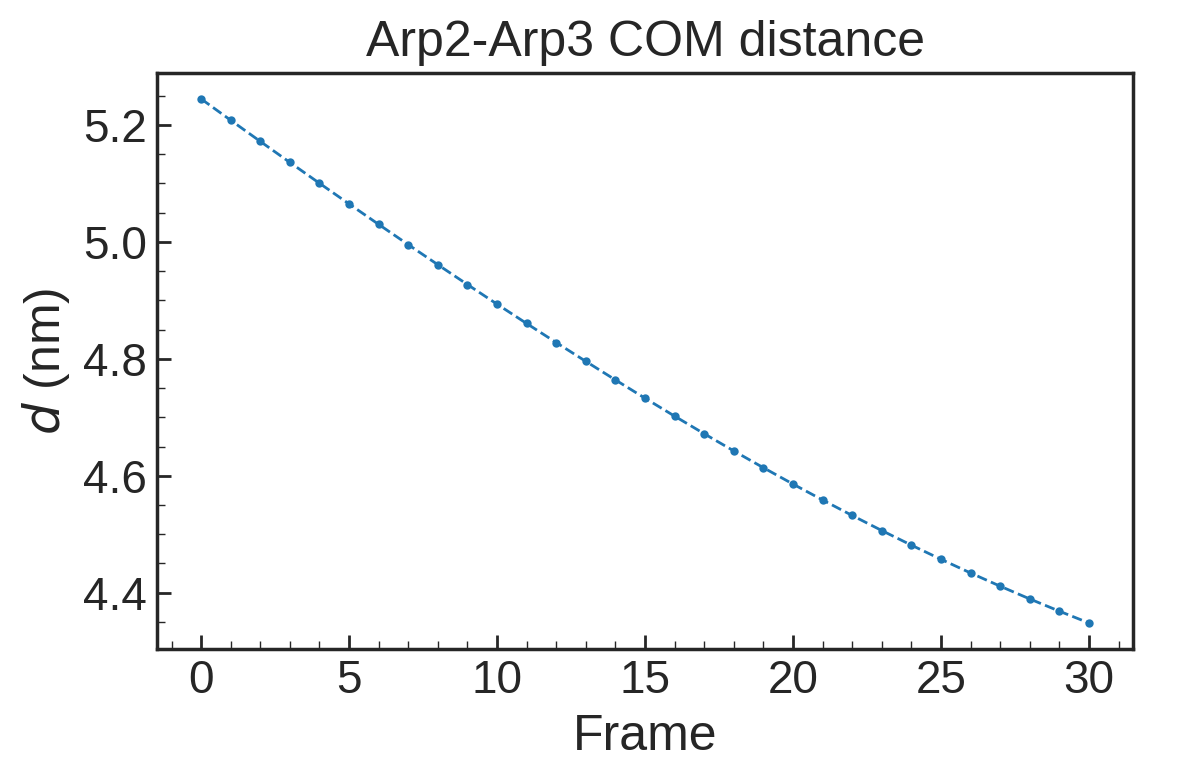

In [7]:
i=4
plt.figure(dpi=200)
plt.title("Arp2-Arp3 COM distance")
plt.plot(morph_cg[4],linewidth=1,marker="o",linestyle="--", markersize=2)

plt.tick_params(direction='in',which='major',length=5, width=1)
plt.tick_params(direction='in',which='minor',length=3, width=0.5)
plt.minorticks_on()

plt.xlabel("Frame")
plt.ylabel("$d$ (nm)")
plt.legend(loc=(1,0),ncol=1,fontsize=12,frameon=False)

plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_COM_dist_cg.png", dpi=200)


### For all others

In [8]:
%%time

trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

trj=full
prefix=full_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1, x2, x3, x4 = get_angle_dist_arp23(trj)
x5 = get_com_dist_arp23(trj)

# this step writes the output
outfile=prefix+".cg_quantities.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5)))

BtArp23_splay/BtArp23_splay_seglabel.cg_quantities.txt
7TPT/7TPT_seglabel.cg_quantities.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.cg_quantities.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.cg_quantities.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.cg_quantities.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.cg_quantities.txt
CPU times: user 46.7 s, sys: 2.87 s, total: 49.6 s
Wall time: 43.9 s


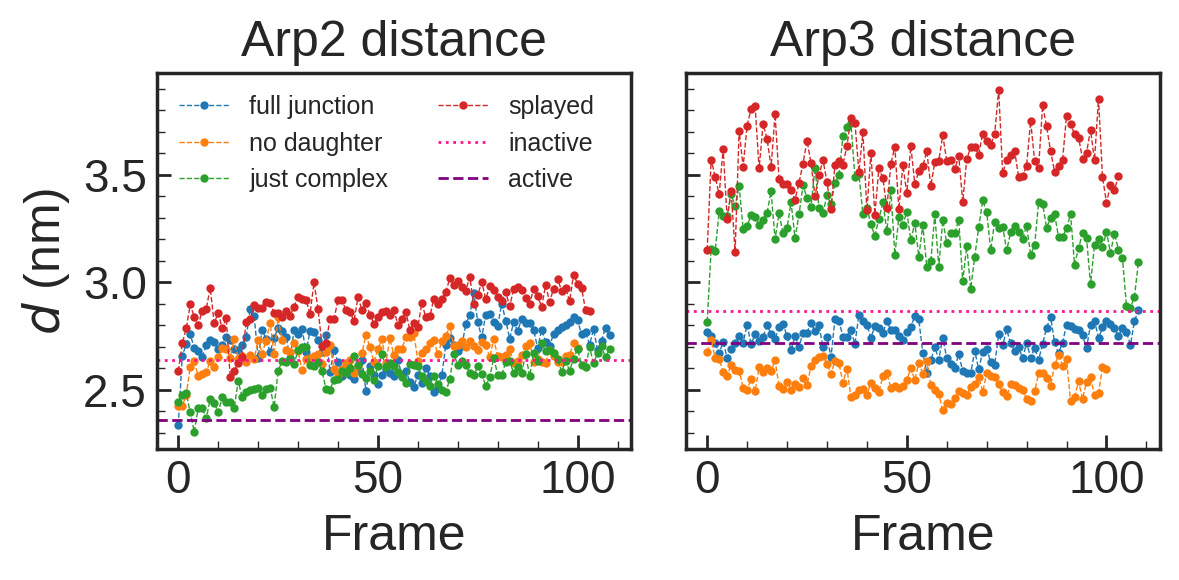

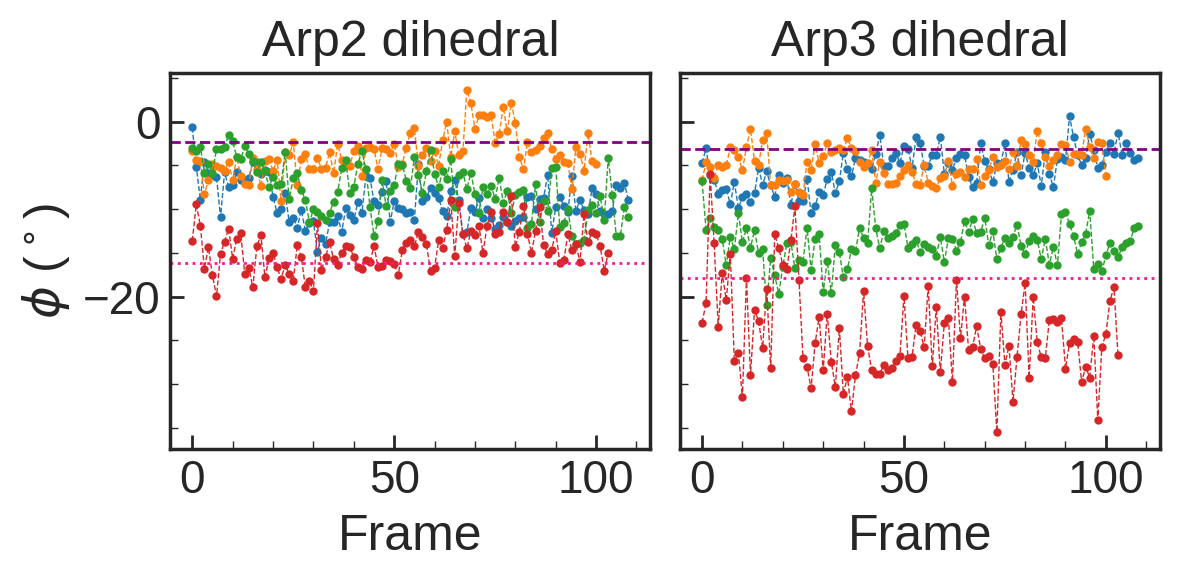

In [9]:
# for plotting, can directly load the output and choose what to plot by specifiying the index: 0,1,2,3,4#
# 0: ARP2 distance, 1: ARP2 dihedral, 2: ARP3 distance, 3: ARP3 dihedral, 4: ARP2-ARP3 com distance
inactive_pdb_cg = np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.cg_quantities.txt")
active_pdb_cg = np.loadtxt("7TPT/7TPT_seglabel.cg_quantities.txt")
full_cg = np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.cg_quantities.txt")
nodaughter_cg = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.cg_quantities.txt")
justcomplex_cg = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.cg_quantities.txt")
splayed_cg = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.cg_quantities.txt")

i=0 # the index value
fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

ax[0].set_title("Arp2 distance")
ax[0].plot(full_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0].plot(nodaughter_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[0].plot(justcomplex_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0].plot(splayed_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0].axhline(inactive_pdb_cg[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0].axhline(active_pdb_cg[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("$d$ (nm)")

ax[0].legend(loc="upper left",ncol=2, frameon=False,fontsize=9)

i=2 # the index value
ax[1].set_title("Arp3 distance")
ax[1].plot(full_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1].plot(nodaughter_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[1].plot(justcomplex_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1].plot(splayed_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1].axhline(inactive_pdb_cg[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1].axhline(active_pdb_cg[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")
plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_distance_cg.png", dpi=200)

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=1 # the index value
ax[0].set_title("Arp2 dihedral")
ax[0].plot(full_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0].plot(nodaughter_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[0].plot(justcomplex_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0].plot(splayed_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0].axhline(inactive_pdb_cg[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0].axhline(active_pdb_cg[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()

ax[0].set_xlabel("Frame")
#ax[0].legend(loc="upper left",ncol=2, frameon=False,fontsize=7.5)
ax[0].set_ylabel("$\phi$ ($^\circ$)")

i=3 # the index value
ax[1].set_title("Arp3 dihedral")
ax[1].plot(full_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1].plot(nodaughter_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[1].plot(justcomplex_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1].plot(splayed_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1].axhline(inactive_pdb_cg[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1].axhline(active_pdb_cg[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")

plt.tight_layout()

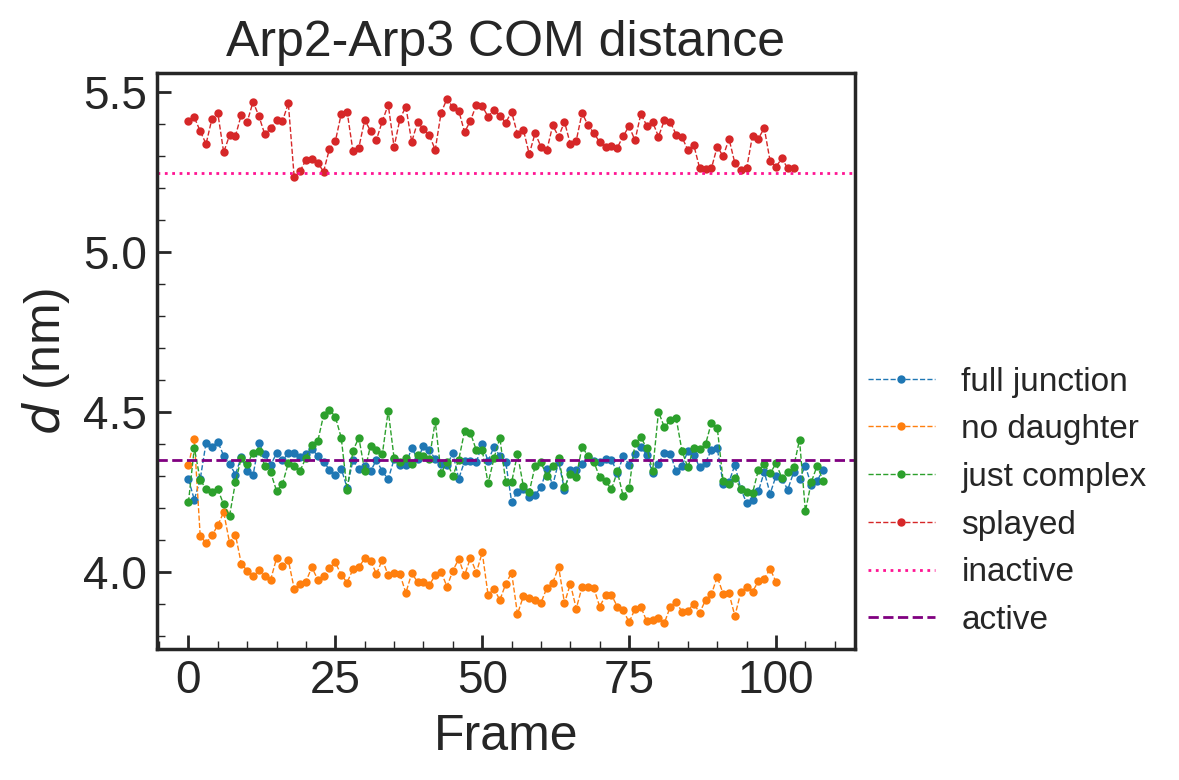

In [10]:
i=4
plt.figure(dpi=200)
plt.title("Arp2-Arp3 COM distance")
plt.plot(full_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
plt.plot(nodaughter_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
plt.plot(justcomplex_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
plt.plot(splayed_cg[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

plt.axhline(inactive_pdb_cg[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
plt.axhline(active_pdb_cg[i],label='active',linestyle='--',color="purple",linewidth=1)

plt.tick_params(direction='in',which='major',length=5, width=1)
plt.tick_params(direction='in',which='minor',length=3, width=0.5)
plt.minorticks_on()

plt.xlabel("Frame")
plt.ylabel("$d$ (nm)")
plt.legend(loc=(1,0),ncol=1,fontsize=12,frameon=False)

plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_COM_dist_cg.png", dpi=200)


# Key Distances

## Twisting/Flattening

In [11]:
# can change which atoms to compute the distance of
def get_residue_distance(trj,segname, res1,res2,atom1='CA',atom2='CA'):
    atom1 = trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname,res1,atom1))[0]
    atom2 = trj.top.select("segname '%s' and residue %i \
                               and name '%s'"%(segname,res2,atom2))[0]
    distances = md.compute_distances(trj,((atom1,atom2),),periodic=True)
    return distances[:,0]

# Other distances
def other_distances(trj):
    # can change the residue numbers, segname
    d2_116_187 = get_residue_distance(trj, 'ARP2', 116, 187)
    d2_72_211 = get_residue_distance(trj,'ARP2',72,211)
    d3_119_198 = get_residue_distance(trj,'ARP3',119,198)
    d3_76_222 = get_residue_distance(trj,'ARP3',76,222)
    return d2_116_187, d2_72_211, d3_119_198, d3_76_222


### For the morph

In [12]:
trj=morph
prefix=morph_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

morph/4jd2_to_branch_morph_seglabels.Twisting_Flattening.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


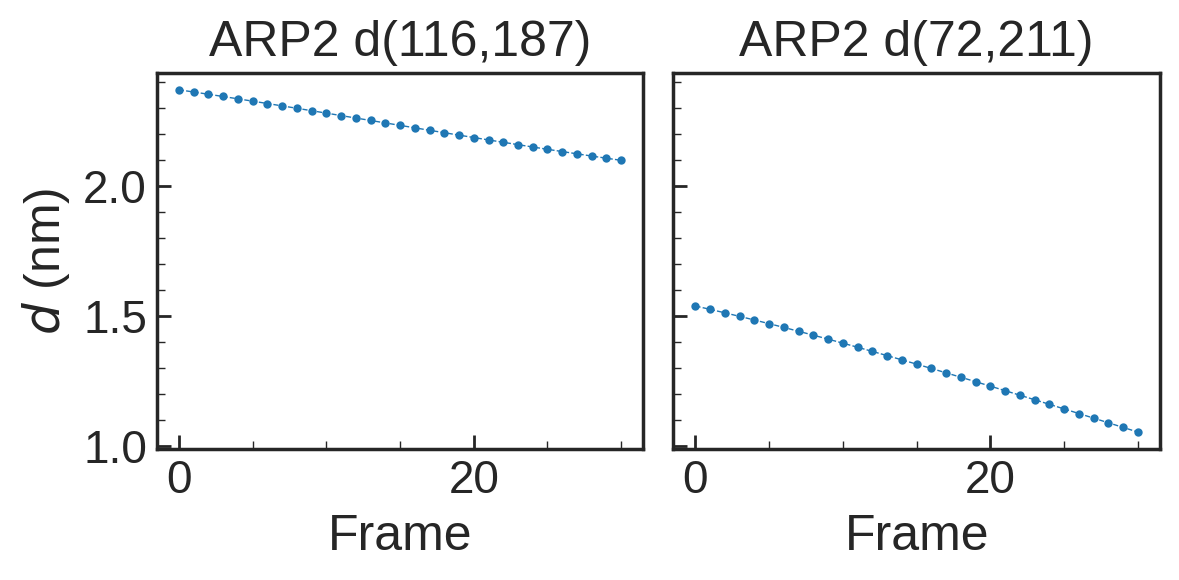

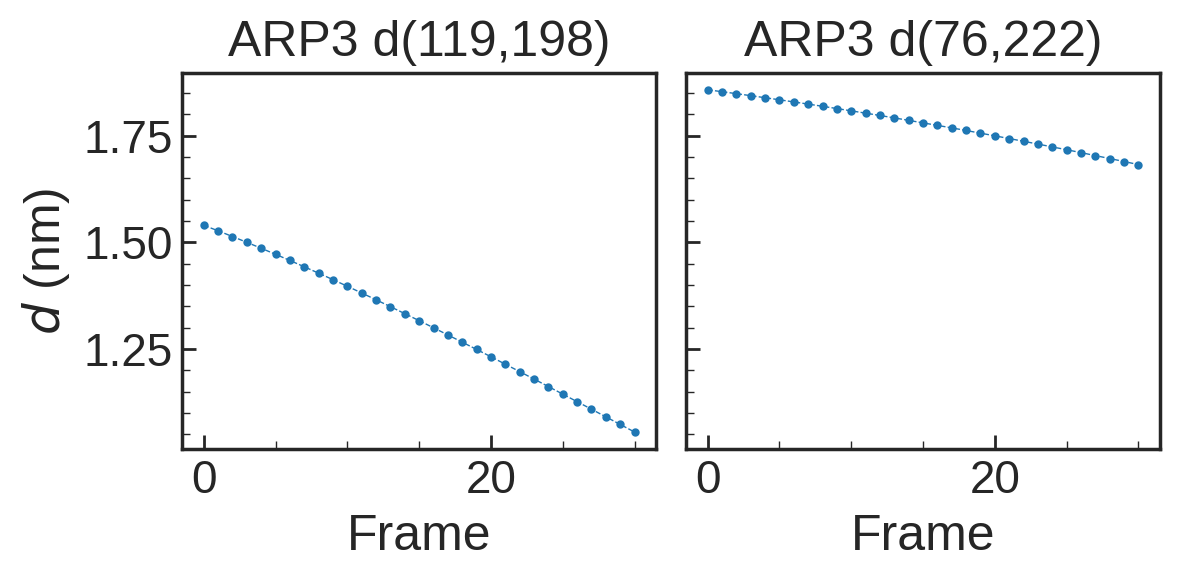

In [13]:
# for plotting, can directly load the output and choose what to plot by specifiying the index: 0,1,2,3,4#
# 0: d2_116_187, 1: d2_72_211, 2: d3_119_198, 3: d3_76_222
morph_twist=np.loadtxt("morph/4jd2_to_branch_morph_seglabels.Twisting_Flattening.txt")
                       
label1 = "ARP2 d(116,187)"
label2 = "ARP2 d(72,211)"
label3 = "ARP3 d(119,198)"
label4 = "ARP3 d(76,222)"

i=0 # the index value
fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

ax[0].set_title(label1)
ax[0].plot(morph_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("$d$ (nm)")

ax[0].legend(loc="upper left",ncol=1, frameon=False,fontsize=9)

i=1 # the index value
ax[1].set_title(label2)
ax[1].plot(morph_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")
plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_distance_cg.png", dpi=200)

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=1 # the index value
ax[0].set_title(label3)
ax[0].plot(morph_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()

ax[0].set_xlabel("Frame")
#ax[0].legend(loc="upper left",ncol=2, frameon=False,fontsize=7.5)
ax[0].set_ylabel("$d$ (nm)")

i=3 # the index value
ax[1].set_title(label4)
ax[1].plot(morph_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")

plt.tight_layout()

### For all others

In [14]:
trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=full
prefix=full_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1, x2, x3, x4 = other_distances(trj)

# this step writes the output
outfile=prefix+".Twisting_Flattening.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))


BtArp23_splay/BtArp23_splay_seglabel.Twisting_Flattening.txt
7TPT/7TPT_seglabel.Twisting_Flattening.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.Twisting_Flattening.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.Twisting_Flattening.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.Twisting_Flattening.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.Twisting_Flattening.txt


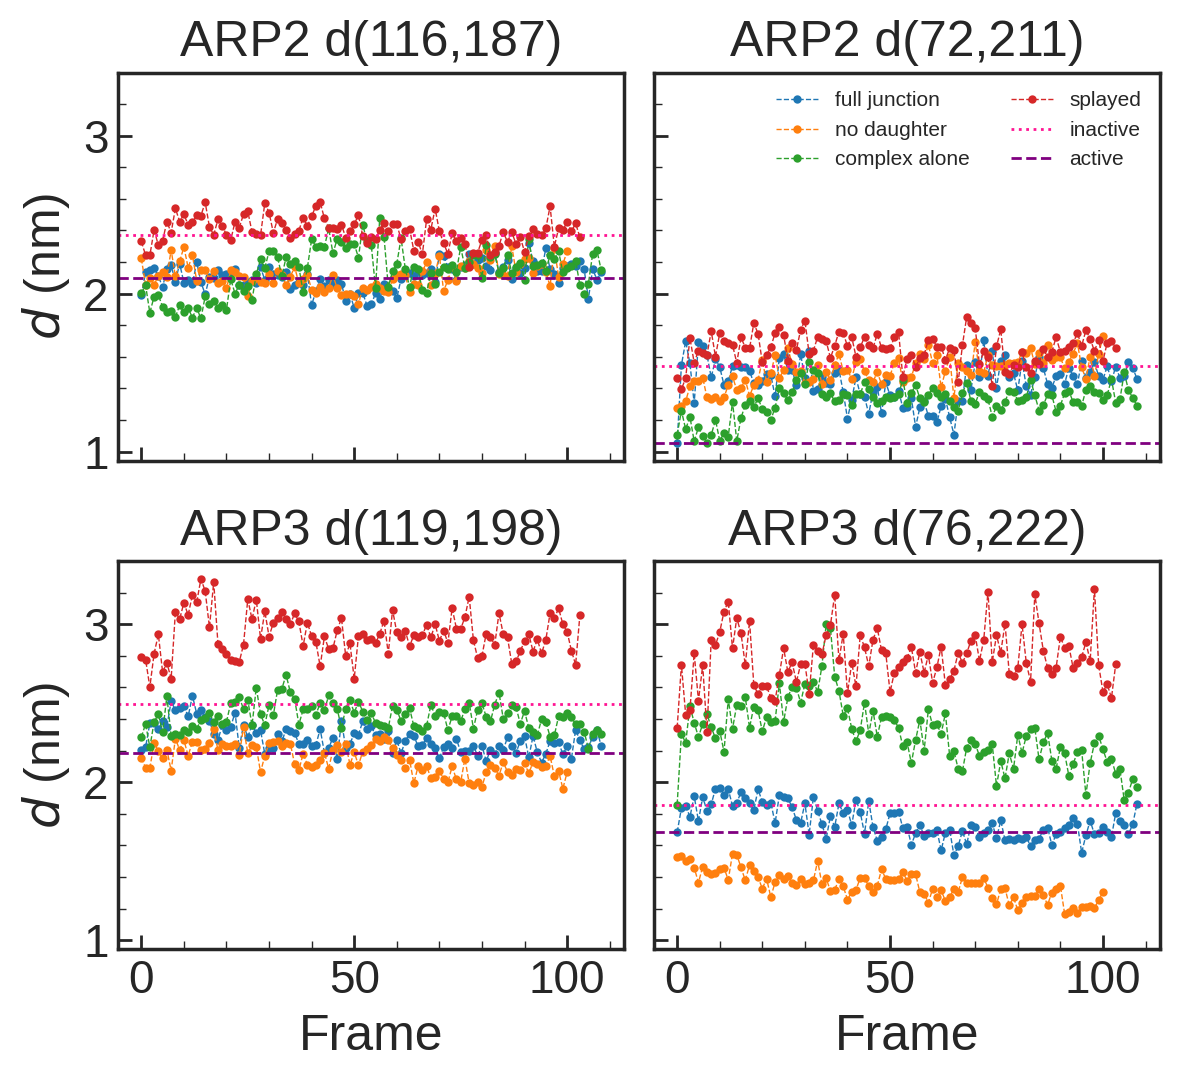

In [15]:
inactive_pdb_twist=np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.Twisting_Flattening.txt")
active_pdb_twist=np.loadtxt("7TPT/7TPT_seglabel.Twisting_Flattening.txt")
full_twist=np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.Twisting_Flattening.txt")
nodaughter_twist = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.Twisting_Flattening.txt")
justcomplex_twist = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.Twisting_Flattening.txt")
splayed_twist = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.Twisting_Flattening.txt")

label1 = "ARP2 d(116,187)"
label2 = "ARP2 d(72,211)"
label3 = "ARP3 d(119,198)"
label4 = "ARP3 d(76,222)"

fig, ax = plt.subplots(2,2,figsize=(6,5.5),sharex=True,sharey=True,dpi=200,edgecolor='k')
i=0 # the index value
ax[0,0].set_title(label1)
ax[0,0].plot(full_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0,0].plot(nodaughter_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[0,0].plot(justcomplex_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="complex alone")
ax[0,0].plot(splayed_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0,0].axhline(inactive_pdb_twist[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0,0].axhline(active_pdb_twist[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[0,0].set_ylabel("$d$ (nm)")
ax[0,0].tick_params(direction='in',which='major',length=5, width=1)
ax[0,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,0].minorticks_on()

i=1 # the index value
ax[0,1].set_title(label2)
ax[0,1].plot(full_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0,1].plot(nodaughter_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[0,1].plot(justcomplex_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="complex alone")
ax[0,1].plot(splayed_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0,1].axhline(inactive_pdb_twist[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0,1].axhline(active_pdb_twist[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[0,1].tick_params(direction='in',which='major',length=5, width=1)
ax[0,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,1].minorticks_on()
ax[0,1].legend(loc="best",ncol=2, frameon=False,fontsize=7.5)

i=2 # the index value
ax[1,0].set_title(label3)
ax[1,0].plot(full_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1,0].plot(nodaughter_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[1,0].plot(justcomplex_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="complex alone")
ax[1,0].plot(splayed_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1,0].axhline(inactive_pdb_twist[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1,0].axhline(active_pdb_twist[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("$d$ (nm)")
ax[1,0].tick_params(direction='in',which='major',length=5, width=1)
ax[1,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,0].minorticks_on()

i=3 # the index value
ax[1,1].set_title(label4)
ax[1,1].plot(full_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1,1].plot(nodaughter_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[1,1].plot(justcomplex_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="complex alone")
ax[1,1].plot(splayed_twist[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1,1].axhline(inactive_pdb_twist[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1,1].axhline(active_pdb_twist[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[1,1].set_xlabel("Frame")
ax[1,1].tick_params(direction='in',which='major',length=5, width=1)
ax[1,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,1].minorticks_on()

plt.tight_layout()
#plt.savefig(fulloutprefix1+".other_distances.png"
plt.tight_layout()

## Helix Bending

In [16]:
# Helix bending

# Can change segnames, and residue numbers below #
def helix_bending(trj):
    helix_bending = get_residue_dist_angle_dihedral(trj,("RPC4","RPC4","RPC4"), (166,143,130))
    return helix_bending


### For the morph

In [17]:
trj=morph
prefix=morph_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

morph/4jd2_to_branch_morph_seglabels.helix_bend.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


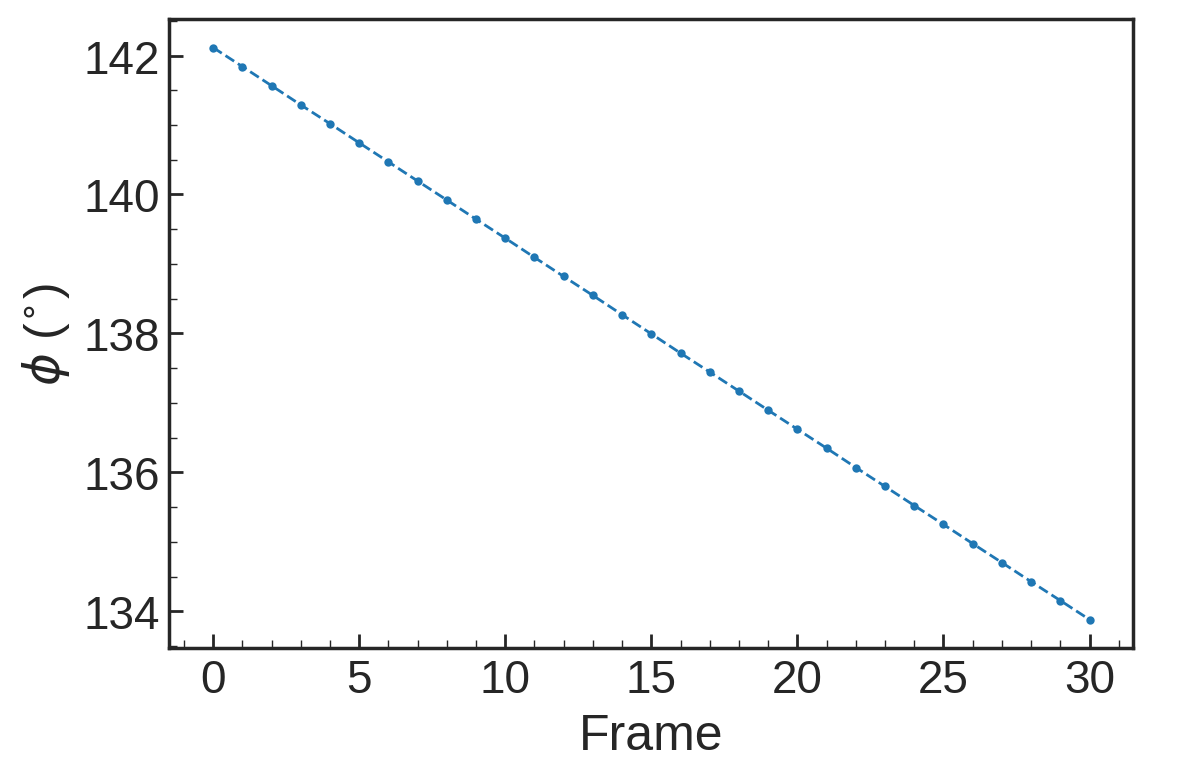

In [18]:
morph_helix=np.loadtxt("morph/4jd2_to_branch_morph_seglabels.helix_bend.txt")
plt.figure(dpi=200)
plt.plot(morph_helix,linewidth=1,marker="o",linestyle="--", markersize=2)

plt.tick_params(direction='in',which='major',length=5, width=1)
plt.tick_params(direction='in',which='minor',length=3, width=0.5)
plt.minorticks_on()

plt.xlabel("Frame")
plt.ylabel("$\\phi$ ($^{\circ}$)")
plt.legend(loc=(1,0),ncol=1,fontsize=12,frameon=False)

plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_COM_dist_cg.png", dpi=200)


### For all others

In [19]:
trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

trj=full
prefix=full_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1 = helix_bending(trj)

# this step writes the output
outfile=prefix+".helix_bend.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1)))



BtArp23_splay/BtArp23_splay_seglabel.helix_bend.txt
7TPT/7TPT_seglabel.helix_bend.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.helix_bend.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.helix_bend.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.helix_bend.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.helix_bend.txt


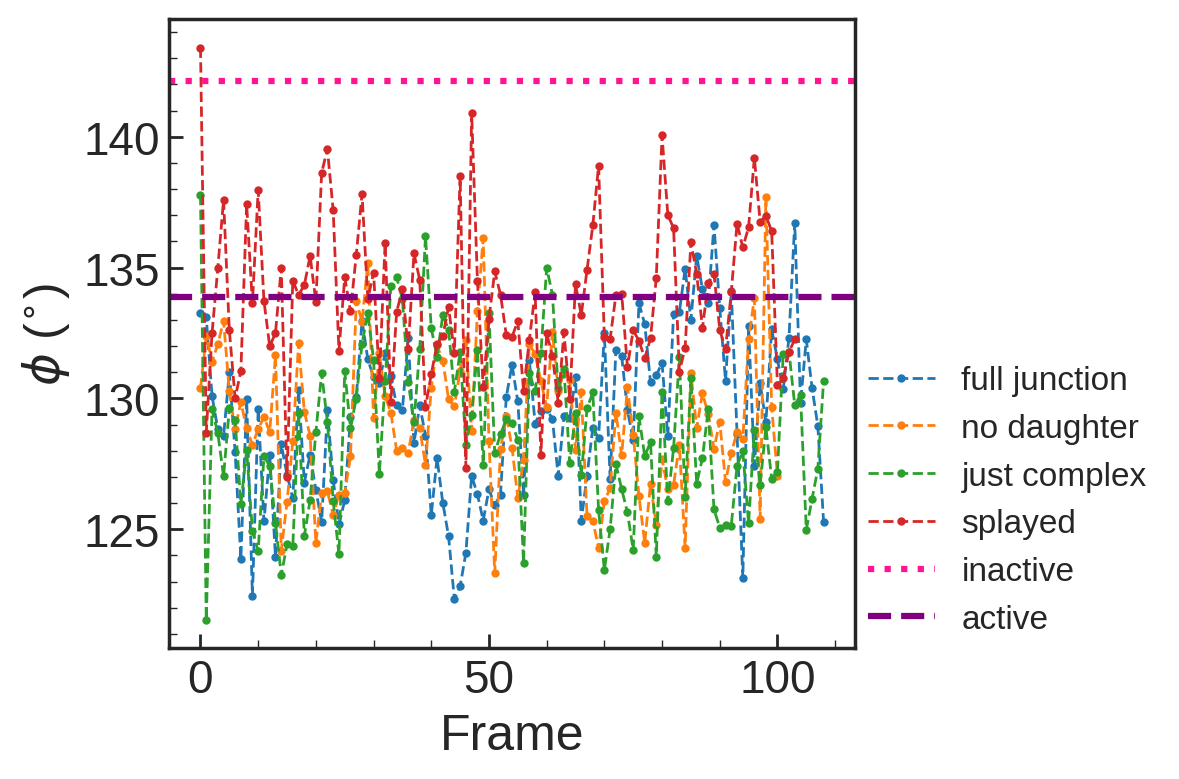

In [20]:
inactive_pdb_helix=np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.helix_bend.txt")
active_pdb_helix = np.loadtxt("7TPT/7TPT_seglabel.helix_bend.txt")
full_helix = np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.helix_bend.txt")
nodaughter_helix = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.helix_bend.txt")
justcomplex_helix = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.helix_bend.txt")
splayed_helix = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.helix_bend.txt")

plt.figure(dpi=200)
plt.plot(full_helix,linewidth=1,marker="o",linestyle="--", markersize=2, label="full junction")
plt.plot(nodaughter_helix,linewidth=1,marker="o",linestyle="--", markersize=2, label="no daughter")
plt.plot(justcomplex_helix,linewidth=1,marker="o",linestyle="--", markersize=2, label="just complex")
plt.plot(splayed_helix,linewidth=1,marker="o",linestyle="--", markersize=2, label="splayed")

plt.axhline(inactive_pdb_helix,linestyle=":",color="deeppink",label="inactive")
plt.axhline(active_pdb_helix,linestyle="--",color="purple",label="active")

plt.tick_params(direction='in',which='major',length=5, width=1)
plt.tick_params(direction='in',which='minor',length=3, width=0.5)
plt.minorticks_on()

plt.xlabel("Frame")
plt.ylabel("$\\phi$ ($^{\circ}$)")
plt.legend(loc=(1,0),ncol=1,fontsize=12,frameon=False)

plt.tight_layout()
#plt.savefig(fulloutprefix1+".ARP2_ARP3_COM_dist_cg.png", dpi=200)


## Movement of C-term groove

In [21]:
# Movement of C-term groove
def c_term_groove(trj):
    d2_152_387 = get_residue_distance(trj,'ARP2',152,387)
    d3_163_409 = get_residue_distance(trj,'ARP3',163,409)
    return d2_152_387, d3_163_409

### For the morph

In [22]:
# x1: d2_152_38 BEG-FB_Arp2, x2: # d3_163_409 BEG-FB_Arp3

trj=morph
prefix=morph_label
# This step does the calculation
x1, x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

morph/4jd2_to_branch_morph_seglabels.c_term_groove.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


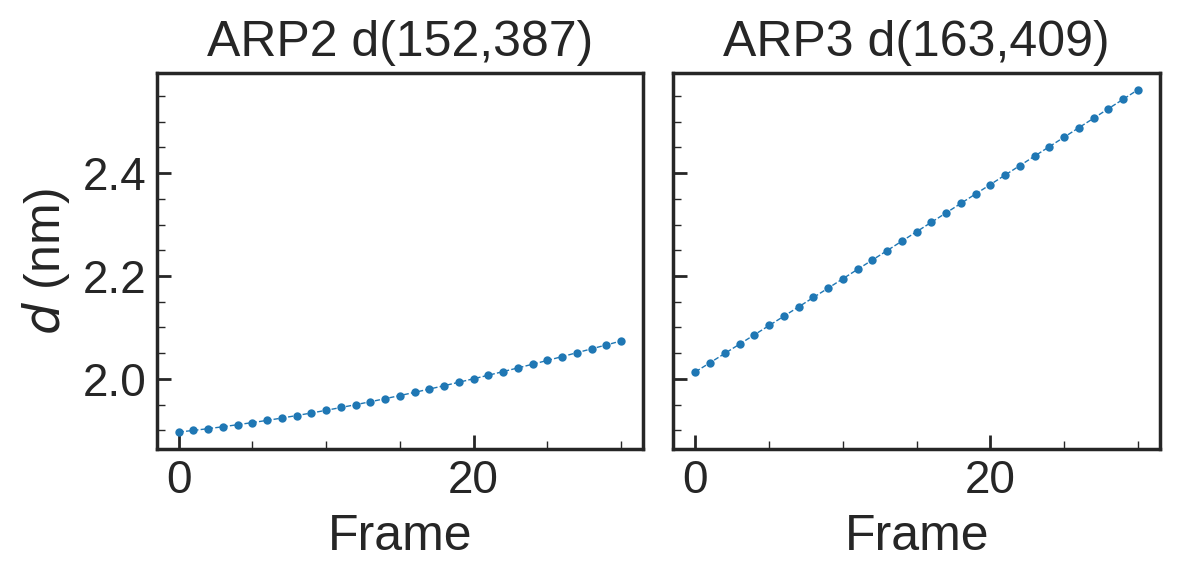

In [23]:
# for plotting, can directly load the output and choose what to plot by specifiying the index: 0,1#
# 0: d2_152_387, 1: d3_163_409

morph_groove = np.loadtxt("morph/4jd2_to_branch_morph_seglabels.c_term_groove.txt")

label1 = "ARP2 d(152,387)"
label2 = "ARP3 d(163,409)"

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0 # the index value
ax[0].set_title(label1)
ax[0].plot(morph_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("$d$ (nm)")

ax[0].legend(loc="upper left",ncol=1, frameon=False,fontsize=9)

i=1 # the index value
ax[1].set_title(label2)
ax[1].plot(morph_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1].minorticks_on()

ax[1].set_xlabel("Frame")
plt.tight_layout()

### For all others

In [24]:
trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

trj=full
prefix=full_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1,x2 = c_term_groove(trj)

# this step writes the output
outfile=prefix+".c_term_groove.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2)))


BtArp23_splay/BtArp23_splay_seglabel.c_term_groove.txt
7TPT/7TPT_seglabel.c_term_groove.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.c_term_groove.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.c_term_groove.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.c_term_groove.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.c_term_groove.txt


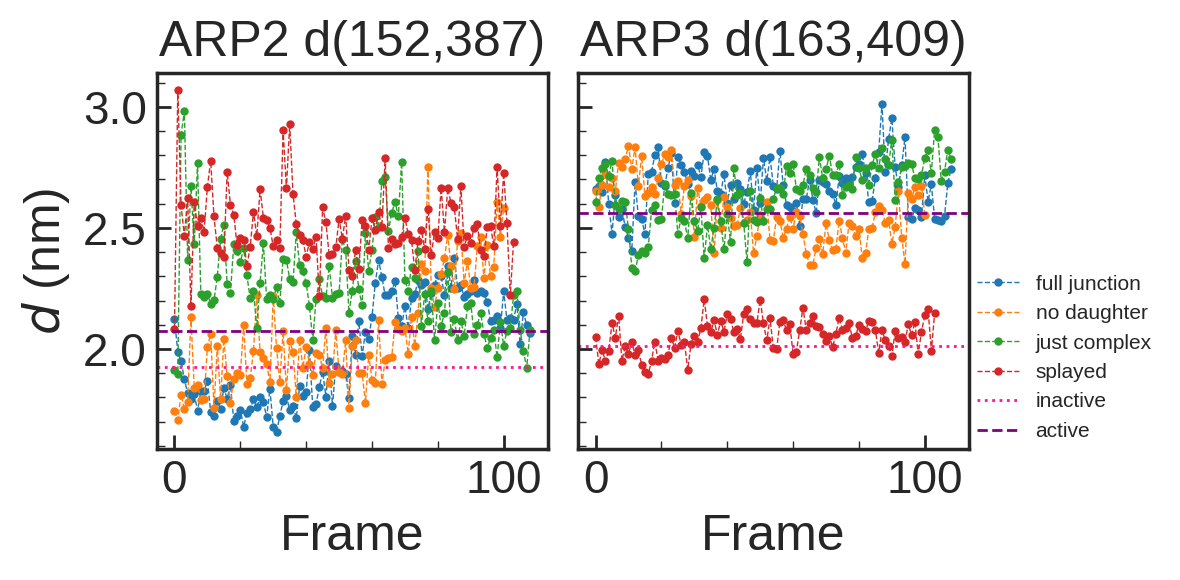

In [25]:
inactive_pdb_groove = np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.c_term_groove.txt")
active_pdb_groove = np.loadtxt("7TPT/7TPT_seglabel.c_term_groove.txt")
full_groove = np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.c_term_groove.txt")
nodaughter_groove = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.c_term_groove.txt")
justcomplex_groove = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.c_term_groove.txt")
splayed_groove = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.c_term_groove.txt")

label1 = "ARP2 d(152,387)"
label2 = "ARP3 d(163,409)"

fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0 # the index value
ax[0].set_title(label1)
ax[0].plot(full_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0].plot(nodaughter_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[0].plot(justcomplex_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0].plot(splayed_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0].axhline(inactive_pdb_groove[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0].axhline(active_pdb_groove[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[0].tick_params(direction='in',which='major',length=5, width=1)
ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0].minorticks_on()
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("$d$ (nm)")

i=1 # the index value
ax[1].set_title(label2)
ax[1].plot(full_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1].plot(nodaughter_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[1].plot(justcomplex_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1].plot(splayed_groove[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1].axhline(inactive_pdb_groove[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1].axhline(active_pdb_groove[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[1].tick_params(direction='in',which='major',length=5, width=1)
ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)

ax[1].legend(loc=(1,0),ncol=1, frameon=False,fontsize=7.5)

ax[1].minorticks_on()

ax[1].set_xlabel("Frame")
plt.tight_layout()

## Opening of BEG, W-loop uncurling

In [26]:
# Opening of BEG, W-loop uncurling
def BEG_Wloop(trj):
    # BEG1
    d2_173_140 = get_residue_distance(trj,'ARP2',173,140)
    d2_173_371 = get_residue_distance(trj,'ARP2',173,371)

    # BEG2
    d3_184_143 = get_residue_distance(trj,'ARP3',184,143)
    d3_184_393 = get_residue_distance(trj,'ARP3',184,393)
    return d2_173_140, d2_173_371, d3_184_143, d3_184_393

### For the morph

In [27]:
# x1: Arp2 d2_173_140 BEG_1 (W-loop uncurling), x2: Arp2 d2_173_371 BEG_2 (Opening of BEG), 
# x3: Arp3 d3_184_143 BEG_1 (W-loop uncurling), x4: Arp3 d3_184_393 BEG_2 (Opening of BEG)

trj=morph
prefix=morph_label
# This step does the calculation
x1, x2, x3, x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

morph/4jd2_to_branch_morph_seglabels.BEG_Wloop.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


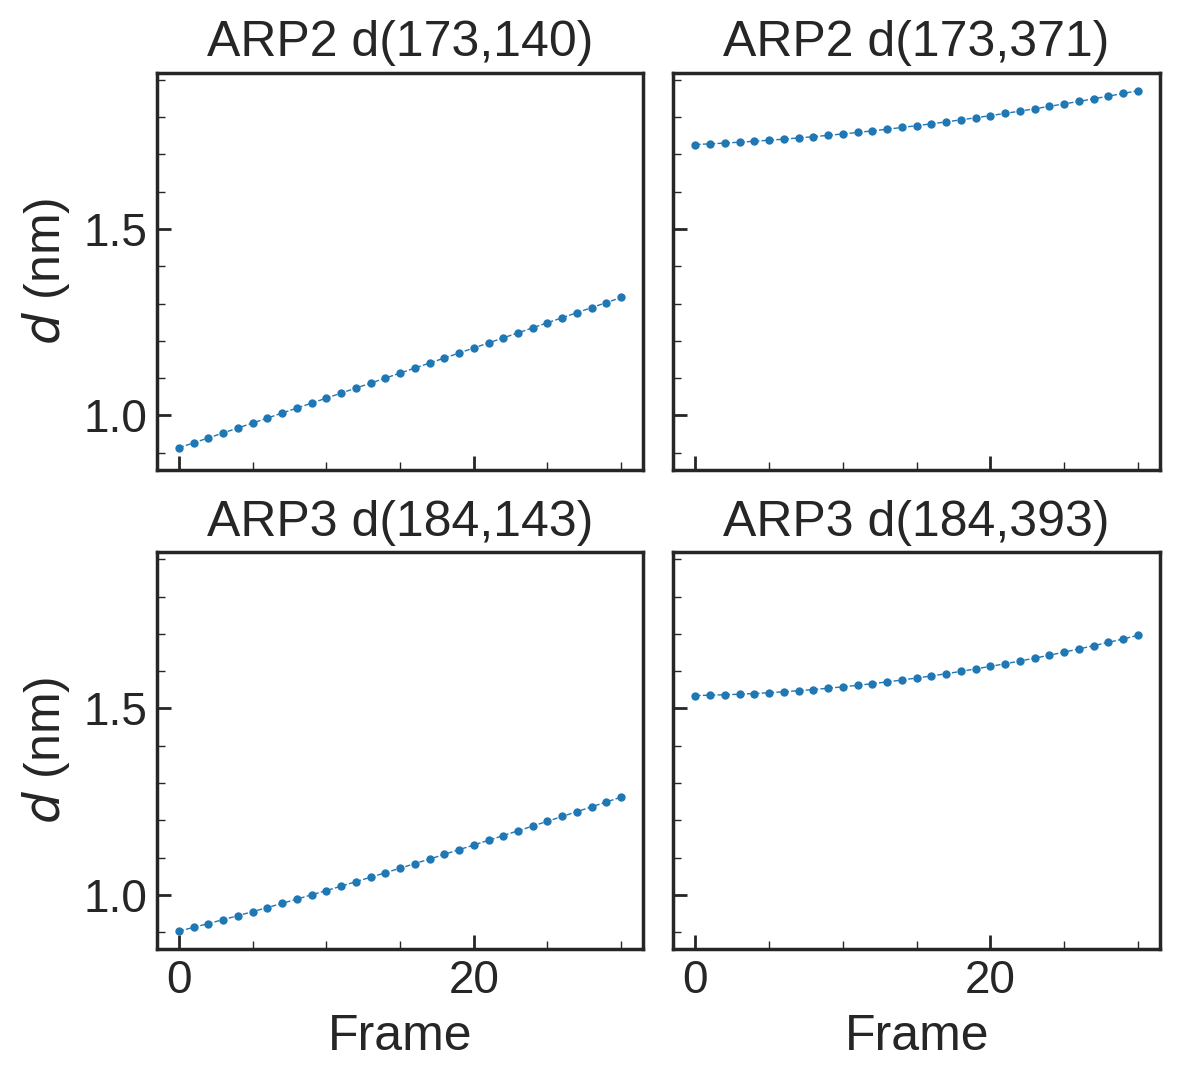

In [28]:
# for plotting, can directly load the output and choose what to plot by specifiying the index: 0,1,2,3 #
# 0: d2_173_140, 1: d2_173_371, 2:d3_184_143, 3: d3_184_393

morph_BEG_Wloop = np.loadtxt("morph/4jd2_to_branch_morph_seglabels.BEG_Wloop.txt")

label1 = "ARP2 d(173,140)"
label2 = "ARP2 d(173,371)"
label3 = "ARP3 d(184,143)"
label4 = "ARP3 d(184,393)"

fig, ax = plt.subplots(2,2,figsize=(6,5.5),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0
ax[0,0].set_title(label1)
ax[0,0].plot(morph_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[0,0].set_ylabel("$d$ (nm)")
ax[0,0].legend(loc="upper left",ncol=2, frameon=False,fontsize=7.5)
ax[0,0].tick_params(direction='in',which='major',length=5, width=1)
ax[0,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,0].minorticks_on()

i=1
ax[0,1].set_title(label2)
ax[0,1].plot(morph_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[0,1].tick_params(direction='in',which='major',length=5, width=1)
ax[0,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,1].minorticks_on()

i=2
ax[1,0].set_title(label3)
ax[1,0].plot(morph_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("$d$ (nm)")
ax[1,0].tick_params(direction='in',which='major',length=5, width=1)
ax[1,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,0].minorticks_on()

i=3
ax[1,1].set_title(label4)
ax[1,1].plot(morph_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[1,1].set_xlabel("Frame")
ax[1,1].tick_params(direction='in',which='major',length=5, width=1)
ax[1,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,1].minorticks_on()

plt.tight_layout()
#plt.savefig(fulloutprefix1+".BEG_Wloop.png", dpi=200)


In [29]:
trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=full
prefix=full_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1,x2,x3,x4 = BEG_Wloop(trj)

# this step writes the output
outfile=prefix+".BEG_Wloop.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4)))


BtArp23_splay/BtArp23_splay_seglabel.BEG_Wloop.txt
7TPT/7TPT_seglabel.BEG_Wloop.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.BEG_Wloop.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.BEG_Wloop.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.BEG_Wloop.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.BEG_Wloop.txt


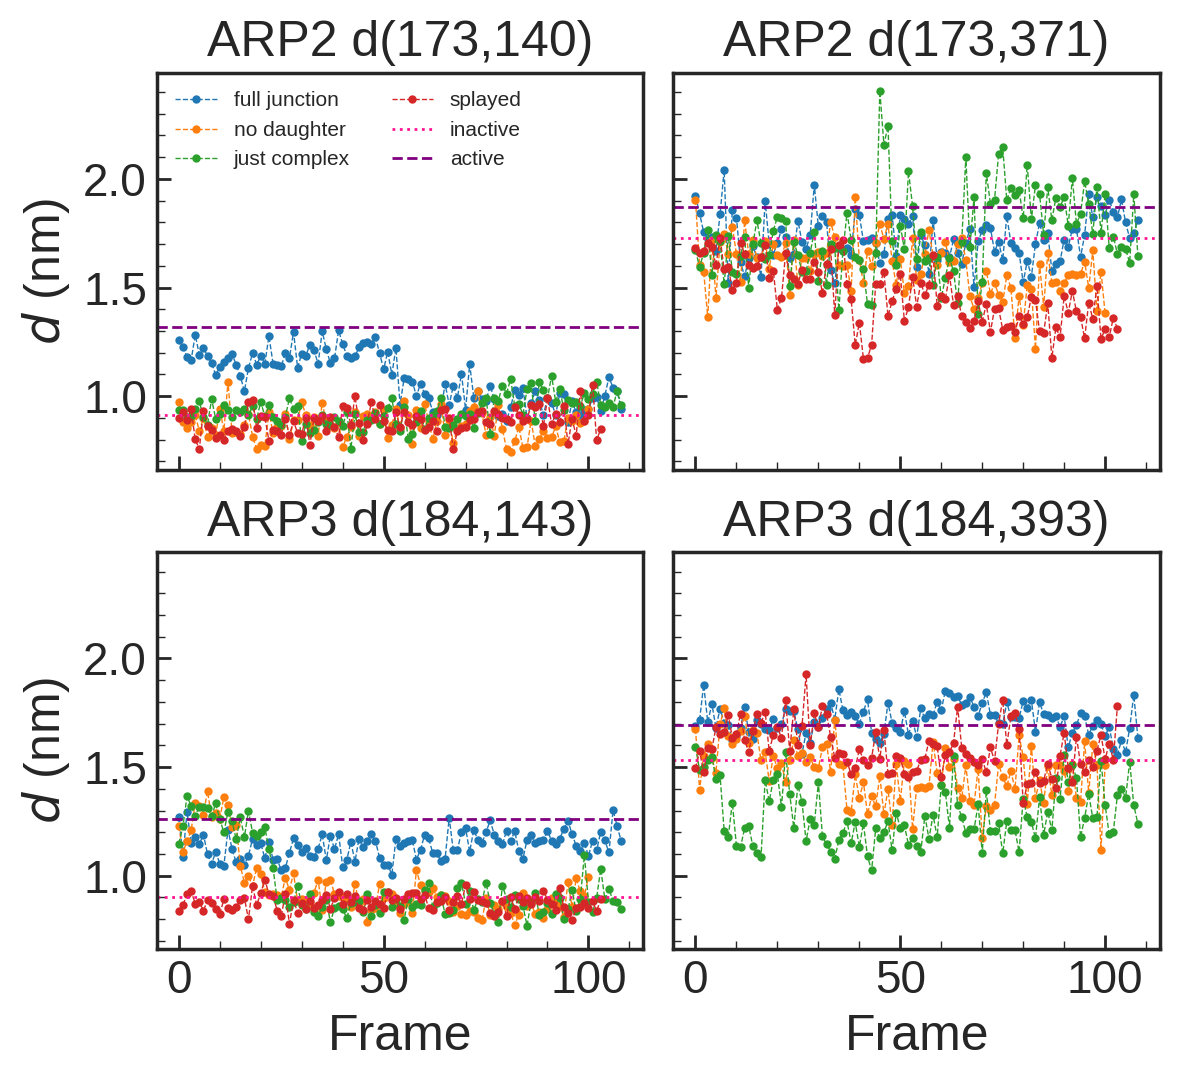

In [30]:
inactive_pdb_BEG_Wloop = np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.BEG_Wloop.txt")
active_pdb_BEG_Wloop = np.loadtxt("7TPT/7TPT_seglabel.BEG_Wloop.txt")
full_BEG_Wloop = np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.BEG_Wloop.txt")
nodaughter_BEG_Wloop = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.BEG_Wloop.txt")
justcomplex_BEG_Wloop = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.BEG_Wloop.txt")
splayed_BEG_Wloop = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.BEG_Wloop.txt")

label1 = "ARP2 d(173,140)"
label2 = "ARP2 d(173,371)"
label3 = "ARP3 d(184,143)"
label4 = "ARP3 d(184,393)"

fig, ax = plt.subplots(2,2,figsize=(6,5.5),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0
ax[0,0].set_title(label1)
ax[0,0].plot(full_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0,0].plot(nodaughter_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[0,0].plot(justcomplex_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0,0].plot(splayed_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0,0].axhline(inactive_pdb_BEG_Wloop[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0,0].axhline(active_pdb_BEG_Wloop[i],label='active',linestyle='--',color="purple",linewidth=1)

ax[0,0].set_ylabel("$d$ (nm)")
ax[0,0].legend(loc="upper left",ncol=2, frameon=False,fontsize=7.5)
ax[0,0].tick_params(direction='in',which='major',length=5, width=1)
ax[0,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,0].minorticks_on()

i=1
ax[0,1].set_title(label2)
ax[0,1].plot(full_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[0,1].plot(nodaughter_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[0,1].plot(justcomplex_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0,1].plot(splayed_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[0,1].axhline(inactive_pdb_BEG_Wloop[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[0,1].axhline(active_pdb_BEG_Wloop[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[0,1].tick_params(direction='in',which='major',length=5, width=1)
ax[0,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,1].minorticks_on()

i=2
ax[1,0].set_title(label3)
ax[1,0].plot(full_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1,0].plot(nodaughter_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[1,0].plot(justcomplex_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1,0].plot(splayed_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1,0].axhline(inactive_pdb_BEG_Wloop[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1,0].axhline(active_pdb_BEG_Wloop[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("$d$ (nm)")
ax[1,0].tick_params(direction='in',which='major',length=5, width=1)
ax[1,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,0].minorticks_on()

i=3
ax[1,1].set_title(label4)
ax[1,1].plot(full_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="full junction")
ax[1,1].plot(nodaughter_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="no daughter")
ax[1,1].plot(justcomplex_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1,1].plot(splayed_BEG_Wloop[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")

ax[1,1].axhline(inactive_pdb_BEG_Wloop[i],label='inactive',linestyle=':',color="deeppink",linewidth=1)
ax[1,1].axhline(active_pdb_BEG_Wloop[i],label='active',linestyle='--',color="purple",linewidth=1)
ax[1,1].set_xlabel("Frame")
ax[1,1].tick_params(direction='in',which='major',length=5, width=1)
ax[1,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,1].minorticks_on()

plt.tight_layout()
#plt.savefig(fulloutprefix1+".BEG_Wloop.png", dpi=200)


## Cleft opening/closing

In [31]:
def cleft_opening_closing(trj):
    # Arp2
    d2_15_162 = get_residue_distance(trj,'ARP2',15,162)
    d2_16_161 = get_residue_distance(trj,'ARP2',16,161)
    d2_62_211 = get_residue_distance(trj,'ARP2',62,211)

    # Arp3
    d3_14_173 = get_residue_distance(trj,'ARP3',14,173)
    d3_15_172 = get_residue_distance(trj,'ARP3',15,172)
    d3_67_222 = get_residue_distance(trj,'ARP3',67,222)

    return d2_15_162, d2_16_161, d2_62_211, d3_14_173, d3_15_172, d3_67_222

### For the morph

In [32]:
# x1: d2_15_162, x2: d2_16_161, x3: d2_62_211,
# x4: d3_14_173, x5: d3_15_172, x6: d3_67_222

trj=morph
prefix=morph_label
# This step does the calculation
x1, x2, x3, x4, x5, x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

morph/4jd2_to_branch_morph_seglabels.cleft_opening_closing.txt


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


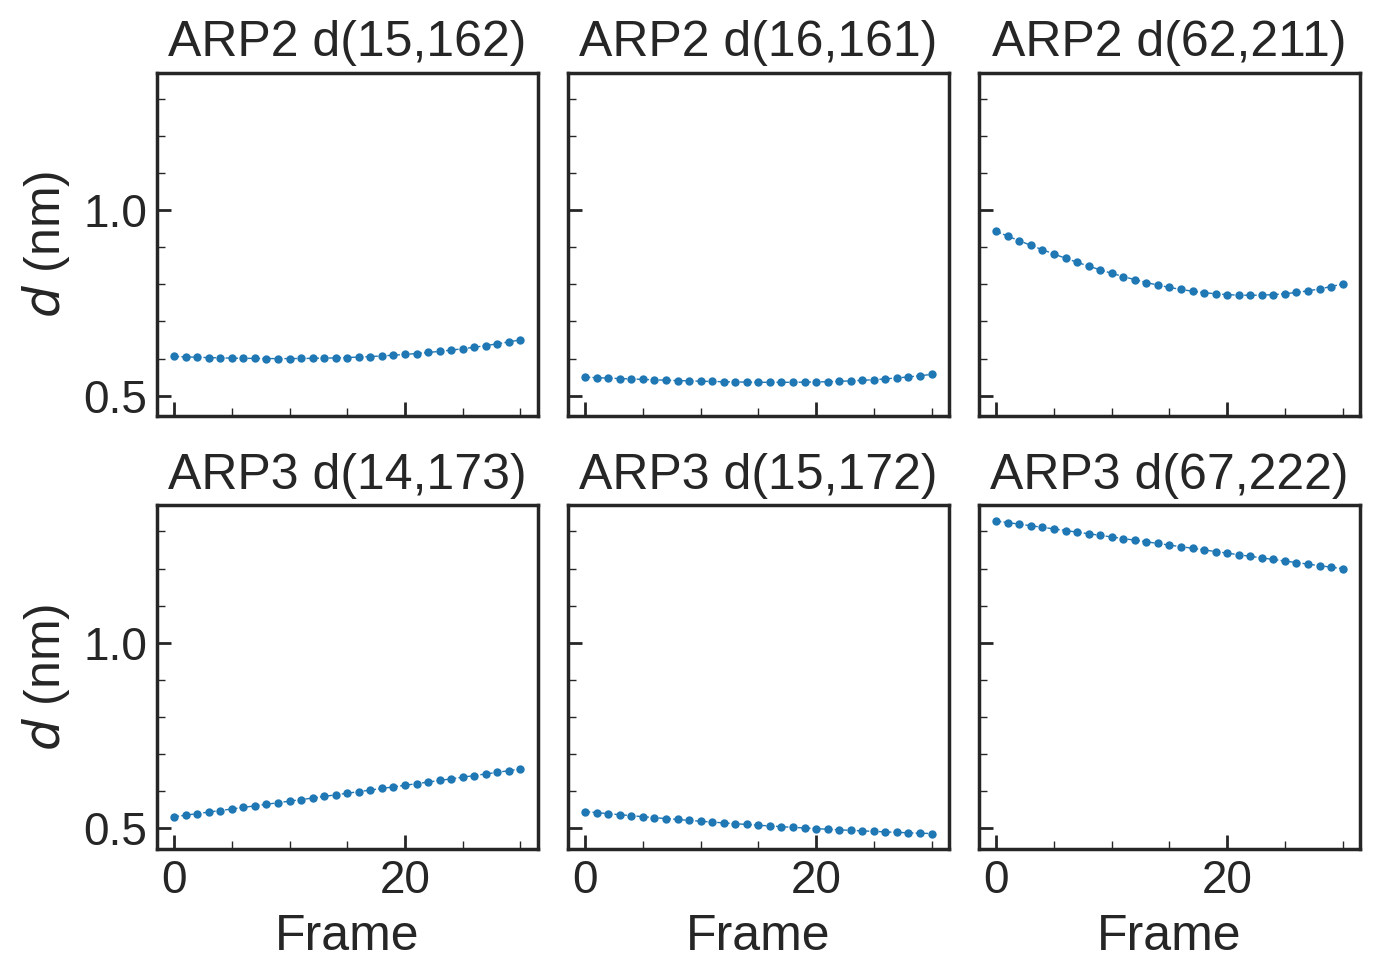

In [33]:
morph_cleft = np.loadtxt("morph/4jd2_to_branch_morph_seglabels.cleft_opening_closing.txt")

label1 = "ARP2 d(15,162)"
label2 = "ARP2 d(16,161)"
label3 = "ARP2 d(62,211)"
label4 = "ARP3 d(14,173)"
label5 = "ARP3 d(15,172)"
label6 = "ARP3 d(67,222)"

fig, ax = plt.subplots(2,3,figsize=(7,5),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0
ax[0,0].set_title(label1)
ax[0,0].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[0,0].set_ylabel("$d$ (nm)")
ax[0,0].tick_params(direction='in',which='major',length=5, width=1)
ax[0,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,0].minorticks_on()
ax[0,0].legend(loc="upper right",ncol=1, frameon=False,fontsize=7)

i=1
ax[0,1].set_title(label2)
ax[0,1].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[0,1].tick_params(direction='in',which='major',length=5, width=1)
ax[0,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,1].legend(loc="upper right",ncol=1, frameon=False,fontsize=7)
ax[0,1].minorticks_on()

i=2
ax[0,2].set_title(label3)
ax[0,2].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[0,2].tick_params(direction='in',which='major',length=5, width=1)
ax[0,2].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,2].minorticks_on()

i=3
ax[1,0].set_title(label4)
ax[1,0].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("$d$ (nm)")
ax[1,0].tick_params(direction='in',which='major',length=5, width=1)
ax[1,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,0].minorticks_on()

i=4
ax[1,1].set_title(label5)
ax[1,1].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[1,1].set_xlabel("Frame")
ax[1,1].tick_params(direction='in',which='major',length=5, width=1)
ax[1,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,1].minorticks_on()

i=5
ax[1,2].set_title(label6)
ax[1,2].plot(morph_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2)
ax[1,2].set_xlabel("Frame")
ax[1,2].tick_params(direction='in',which='major',length=5, width=1)
ax[1,2].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,2].minorticks_on()

plt.tight_layout()
#plt.savefig(fulloutprefix1+".cleft_opening.png", dpi=200)

In [34]:
trj=inactive_pdb
prefix=inactive_pdb_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

trj=active_pdb
prefix=active_pdb_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

trj=full
prefix=full_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

trj=nodaughter
prefix=nodaughter_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

trj=justcomplex
prefix=justcomplex_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))

trj=splayed
prefix=splayed_label
# This step does the calculation
x1,x2,x3,x4,x5,x6 = cleft_opening_closing(trj)

# this step writes the output
outfile=prefix+".cleft_opening_closing.txt"
print(outfile) # this shows where the output was written
np.savetxt(outfile,np.array((x1,x2,x3,x4,x5,x6)))


BtArp23_splay/BtArp23_splay_seglabel.cleft_opening_closing.txt
7TPT/7TPT_seglabel.cleft_opening_closing.txt
full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.cleft_opening_closing.txt
no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.cleft_opening_closing.txt
just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.cleft_opening_closing.txt
splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.cleft_opening_closing.txt


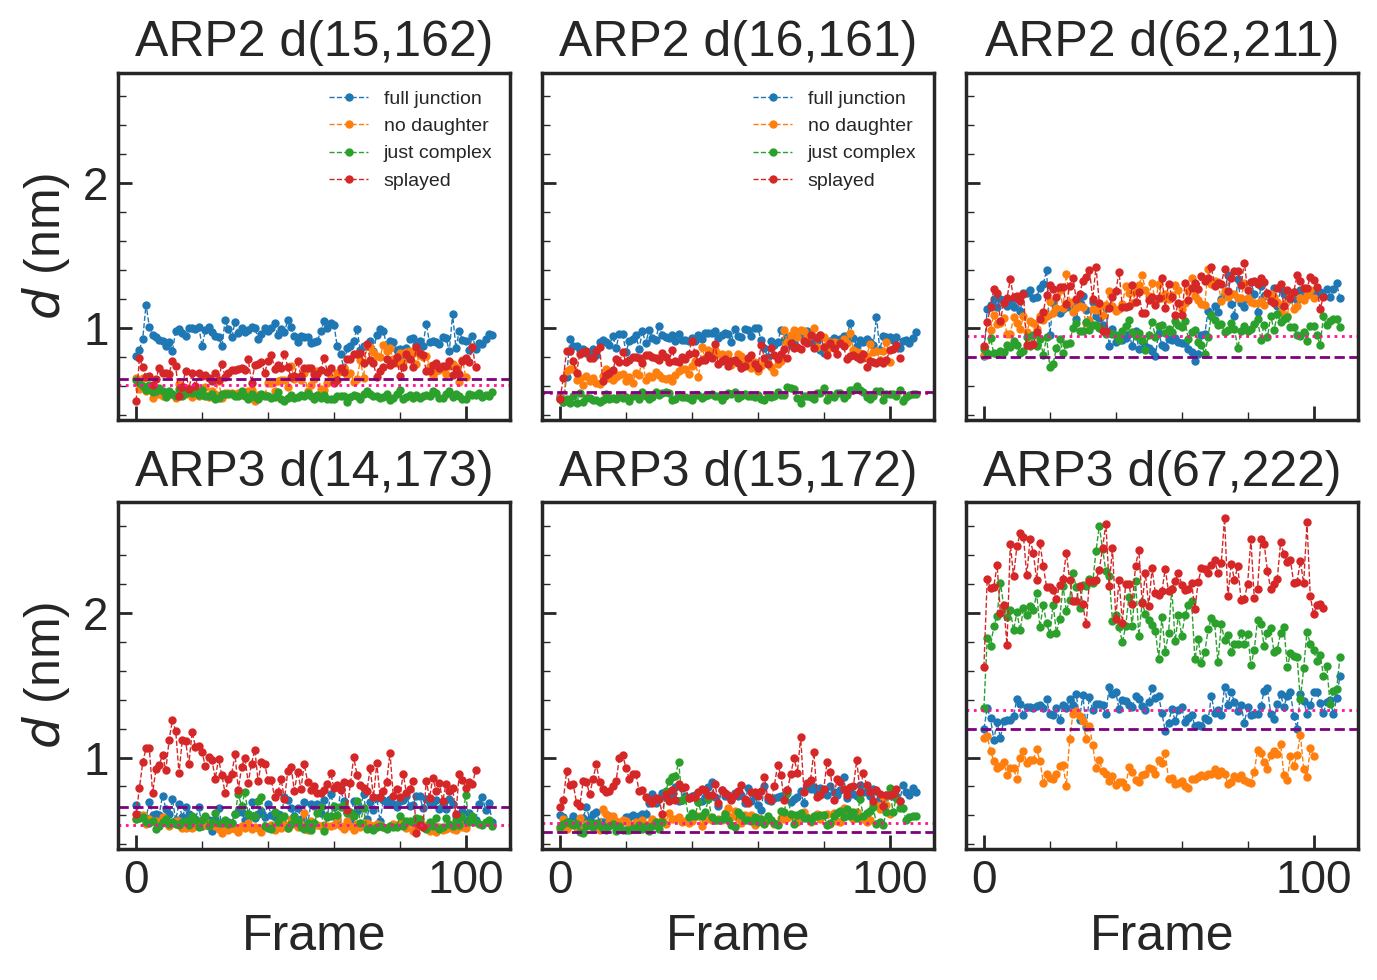

In [35]:
inactive_pdb_cleft = np.loadtxt("BtArp23_splay/BtArp23_splay_seglabel.cleft_opening_closing.txt")
active_pdb_cleft = np.loadtxt("7TPT/7TPT_seglabel.cleft_opening_closing.txt")
full_cleft = np.loadtxt("full_junction/mammalian_junction_full_c27_adjustRpc5_npt_restrained.stepid540000000.every100ns.nowater.cleft_opening_closing.txt")
nodaughter_cleft = np.loadtxt("no_daughter/mammalian_junction_nodaughter_ATP_c27_npt_restrained.stepid500000000.every100ns.nowater.cleft_opening_closing.txt")
justcomplex_cleft = np.loadtxt("just_complex/mammalian_junction_justcomplex_ATP_c27_npt.stepid540000000.every100ns.nowater.cleft_opening_closing.txt")
splayed_cleft = np.loadtxt("splayed/mammalian_justcomplex_splayed_ATP_c27_ionized.stepid525500000.every100ns.nowater.cleft_opening_closing.txt")

label1 = "ARP2 d(15,162)"
label2 = "ARP2 d(16,161)"
label3 = "ARP2 d(62,211)"
label4 = "ARP3 d(14,173)"
label5 = "ARP3 d(15,172)"
label6 = "ARP3 d(67,222)"

fig, ax = plt.subplots(2,3,figsize=(7,5),sharex=True,sharey=True,dpi=200,edgecolor='k')

i=0
ax[0,0].set_title(label1)
ax[0,0].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[0,0].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[0,0].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0,0].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[0,0].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[0,0].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[0,0].set_ylabel("$d$ (nm)")
ax[0,0].tick_params(direction='in',which='major',length=5, width=1)
ax[0,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,0].minorticks_on()
ax[0,0].legend(loc="upper right",ncol=1, frameon=False,fontsize=7)

i=1
ax[0,1].set_title(label2)
ax[0,1].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[0,1].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[0,1].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0,1].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[0,1].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[0,1].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[0,1].tick_params(direction='in',which='major',length=5, width=1)
ax[0,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,1].legend(loc="upper right",ncol=1, frameon=False,fontsize=7)
ax[0,1].minorticks_on()

i=2
ax[0,2].set_title(label3)
ax[0,2].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[0,2].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[0,2].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[0,2].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[0,2].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[0,2].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[0,2].tick_params(direction='in',which='major',length=5, width=1)
ax[0,2].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[0,2].minorticks_on()

i=3
ax[1,0].set_title(label4)
ax[1,0].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[1,0].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[1,0].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1,0].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[1,0].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[1,0].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[1,0].set_xlabel("Frame")
ax[1,0].set_ylabel("$d$ (nm)")
ax[1,0].tick_params(direction='in',which='major',length=5, width=1)
ax[1,0].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,0].minorticks_on()

i=4
ax[1,1].set_title(label5)
ax[1,1].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[1,1].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[1,1].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1,1].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[1,1].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[1,1].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[1,1].set_xlabel("Frame")
ax[1,1].tick_params(direction='in',which='major',length=5, width=1)
ax[1,1].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,1].minorticks_on()

i=5
ax[1,2].set_title(label6)
ax[1,2].plot(full_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="full junction")
ax[1,2].plot(nodaughter_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2,label="no daughter")
ax[1,2].plot(justcomplex_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="just complex")
ax[1,2].plot(splayed_cleft[i],linewidth=0.5,marker="o",linestyle="--", markersize=2, label="splayed")
ax[1,2].axhline(inactive_pdb_cleft[i],linestyle=':',color="deeppink",linewidth=1)
ax[1,2].axhline(active_pdb_cleft[i],linestyle='--',color="purple",linewidth=1)
ax[1,2].set_xlabel("Frame")
ax[1,2].tick_params(direction='in',which='major',length=5, width=1)
ax[1,2].tick_params(direction='in',which='minor',length=3, width=0.5)
ax[1,2].minorticks_on()

plt.tight_layout()
#plt.savefig(fulloutprefix1+".cleft_opening.pn

# General plotting

### This will be used to any quantity calculated

## 1) Looking at one quantity

In [36]:
def plot(X,inactive_value,active_value):

    plt.figure(dpi=200)
    plt.plot(X,linewidth=0.5,marker="o",linestyle="--", markersize=2)

    plt.axhline(inactive_value,label='inactive',linestyle=':',color="deeppink",linewidth=1)
    plt.axhline(active_value,label='active',linestyle='--',color="purple",linewidth=1)

    plt.tick_params(direction='in',which='major',length=5, width=1)
    plt.tick_params(direction='in',which='minor',length=3, width=0.5)
    plt.minorticks_on()

    plt.xlabel("Frame")
    plt.legend(loc=(1,0),ncol=1,fontsize=12,frameon=False)

    plt.tight_layout()        

### Example: The ARP2-ARP3 COM distance from the full junction trajectory

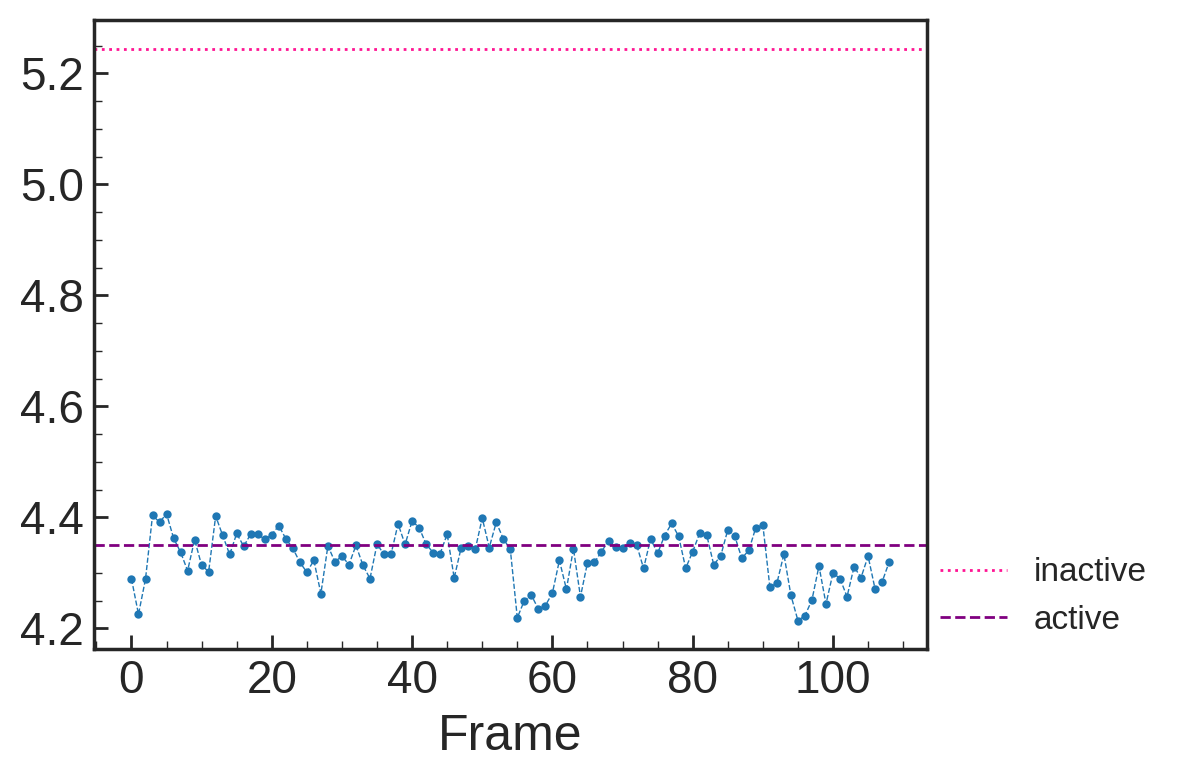

In [37]:
X=full_cg[4]
inactive_value = inactive_pdb_cg[4]
active_value = active_pdb_cg[4]
plot(X,inactive_value,active_value)

## 2) Looking at two quantities

In [38]:
def plot_X1_X2(X1,inactive_X1,active_X1, X2, inactive_X2, active_X2):

    fig, ax = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=False,dpi=200,edgecolor='k')

    ax[0].plot(X1,linewidth=0.5,marker="o",linestyle="--", markersize=2)

    ax[0].axhline(inactive_X1,label='inactive',linestyle=':',color="deeppink",linewidth=1)
    ax[0].axhline(active_X1, label='active',linestyle='--',color="purple",linewidth=1)

    ax[0].tick_params(direction='in',which='major',length=5, width=1)
    ax[0].tick_params(direction='in',which='minor',length=3, width=0.5)
    ax[0].minorticks_on()
    ax[0].set_xlabel("Frame")

    ax[1].plot(X2,linewidth=0.5,marker="o",linestyle="--", markersize=2)

    ax[1].axhline(inactive_X2,label='inactive',linestyle=':',color="deeppink",linewidth=1)
    ax[1].axhline(active_X2, label='active',linestyle='--',color="purple",linewidth=1)
    ax[1].tick_params(direction='in',which='major',length=5, width=1)
    ax[1].tick_params(direction='in',which='minor',length=3, width=0.5)

    ax[1].legend(loc=(1,0),ncol=1, frameon=False,fontsize=7.5)

    ax[1].minorticks_on()

    ax[1].set_xlabel("Frame")
    plt.tight_layout()

### Example: Plotting the Arp2 Twist/flate angle and Arp2 movement into C-terminal groove for the full junction trajectory

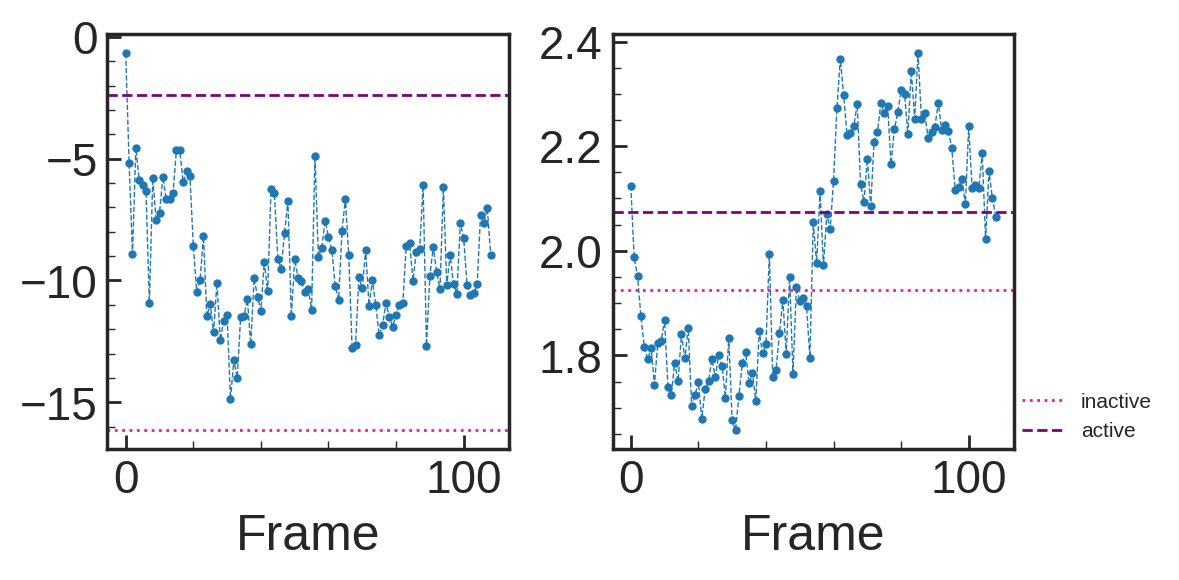

In [39]:
X1=full_cg[1]
inactive_X1=inactive_pdb_cg[1]
active_X1=active_pdb_cg[1]

X2=full_groove[0]
inactive_X2=inactive_pdb_groove[0]
active_X2=active_pdb_groove[0]

plot_X1_X2(X1,inactive_X1,active_X1, X2, inactive_X2, active_X2)

# List of all quantities calculated

## Full junction

In [40]:
print("full_cg[0]: Arp2 distance")
print("full_cg[1]: Arp2 dihedral")
print("full_cg[2]: Arp3 distance")
print("full_cg[3]: Arp3 dihedral")
print("full_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("full_twist[0]: Arp2 d(116,187)")
print("full_twist[1]: Arp2 d(72,211)")
print("full_twist[2]: Arp3 d(119,198)")
print("full_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("full_helix: Helix bending")
print("#######################################################################")
print("full_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("full_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("full_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("full_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("full_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("full_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("full_cleft[0]: Arp2 d(15,162)")
print("full_cleft[1]: Arp2 d(16,161)")
print("full_cleft[2]: Arp2 d(62,211)")
print("full_cleft[3]: Arp3 d(14,173)")
print("full_cleft[4]: Arp3 d(15,172)")
print("full_cleft[5]: Arp3 d(67,222)")

full_cg[0]: Arp2 distance
full_cg[1]: Arp2 dihedral
full_cg[2]: Arp3 distance
full_cg[3]: Arp3 dihedral
full_cg[4]: Arp2-Arp3 COM distance
#######################################################################
full_twist[0]: Arp2 d(116,187)
full_twist[1]: Arp2 d(72,211)
full_twist[2]: Arp3 d(119,198)
full_twist[3]: Arp3 d(76,222)
#######################################################################
full_helix: Helix bending
#######################################################################
full_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
full_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
full_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
full_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
full_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
full_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)
#######################################################################
full_cleft[0]: Arp2 d(15,162)

## No daughter

In [41]:
print("nodaughter_cg[0]: Arp2 distance")
print("nodaughter_cg[1]: Arp2 dihedral")
print("nodaughter_cg[2]: Arp3 distance")
print("nodaughter_cg[3]: Arp3 dihedral")
print("nodaughter_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("nodaughter_twist[0]: Arp2 d(116,187)")
print("nodaughter_twist[1]: Arp2 d(72,211)")
print("nodaughter_twist[2]: Arp3 d(119,198)")
print("nodaughter_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("nodaughter_helix: Helix bending")
print("#######################################################################")
print("nodaughter_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("nodaughter_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("nodaughter_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("nodaughter_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("nodaughter_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("nodaughter_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("nodaughter_cleft[0]: Arp2 d(15,162)")
print("nodaughter_cleft[1]: Arp2 d(16,161)")
print("nodaughter_cleft[2]: Arp2 d(62,211)")
print("nodaughter_cleft[3]: Arp3 d(14,173)")
print("nodaughter_cleft[4]: Arp3 d(15,172)")
print("nodaughter_cleft[5]: Arp3 d(67,222)")

nodaughter_cg[0]: Arp2 distance
nodaughter_cg[1]: Arp2 dihedral
nodaughter_cg[2]: Arp3 distance
nodaughter_cg[3]: Arp3 dihedral
nodaughter_cg[4]: Arp2-Arp3 COM distance
#######################################################################
nodaughter_twist[0]: Arp2 d(116,187)
nodaughter_twist[1]: Arp2 d(72,211)
nodaughter_twist[2]: Arp3 d(119,198)
nodaughter_twist[3]: Arp3 d(76,222)
#######################################################################
nodaughter_helix: Helix bending
#######################################################################
nodaughter_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
nodaughter_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
nodaughter_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
nodaughter_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
nodaughter_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
nodaughter_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)
#####

## Just complex

In [42]:
print("justcomplex_cg[0]: Arp2 distance")
print("justcomplex_cg[1]: Arp2 dihedral")
print("justcomplex_cg[2]: Arp3 distance")
print("justcomplex_cg[3]: Arp3 dihedral")
print("justcomplex_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("justcomplex_twist[0]: Arp2 d(116,187)")
print("justcomplex_twist[1]: Arp2 d(72,211)")
print("justcomplex_twist[2]: Arp3 d(119,198)")
print("justcomplex_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("justcomplex_helix: Helix bending")
print("#######################################################################")
print("justcomplex_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("justcomplex_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("justcomplex_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("justcomplex_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("justcomplex_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("justcomplex_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("justcomplex_cleft[0]: Arp2 d(15,162)")
print("justcomplex_cleft[1]: Arp2 d(16,161)")
print("justcomplex_cleft[2]: Arp2 d(62,211)")
print("justcomplex_cleft[3]: Arp3 d(14,173)")
print("justcomplex_cleft[4]: Arp3 d(15,172)")
print("justcomplex_cleft[5]: Arp3 d(67,222)")

justcomplex_cg[0]: Arp2 distance
justcomplex_cg[1]: Arp2 dihedral
justcomplex_cg[2]: Arp3 distance
justcomplex_cg[3]: Arp3 dihedral
justcomplex_cg[4]: Arp2-Arp3 COM distance
#######################################################################
justcomplex_twist[0]: Arp2 d(116,187)
justcomplex_twist[1]: Arp2 d(72,211)
justcomplex_twist[2]: Arp3 d(119,198)
justcomplex_twist[3]: Arp3 d(76,222)
#######################################################################
justcomplex_helix: Helix bending
#######################################################################
justcomplex_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
justcomplex_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
justcomplex_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
justcomplex_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
justcomplex_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
justcomplex_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Openi

## Splayed

In [43]:
print("splayed_cg[0]: Arp2 distance")
print("splayed_cg[1]: Arp2 dihedral")
print("splayed_cg[2]: Arp3 distance")
print("splayed_cg[3]: Arp3 dihedral")
print("splayed_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("splayed_twist[0]: Arp2 d(116,187)")
print("splayed_twist[1]: Arp2 d(72,211)")
print("splayed_twist[2]: Arp3 d(119,198)")
print("splayed_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("splayed_helix: Helix bending")
print("#######################################################################")
print("splayed_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("splayed_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("splayed_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("splayed_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("splayed_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("splayed_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("splayed_cleft[0]: Arp2 d(15,162)")
print("splayed_cleft[1]: Arp2 d(16,161)")
print("splayed_cleft[2]: Arp2 d(62,211)")
print("splayed_cleft[3]: Arp3 d(14,173)")
print("splayed_cleft[4]: Arp3 d(15,172)")
print("splayed_cleft[5]: Arp3 d(67,222)")

splayed_cg[0]: Arp2 distance
splayed_cg[1]: Arp2 dihedral
splayed_cg[2]: Arp3 distance
splayed_cg[3]: Arp3 dihedral
splayed_cg[4]: Arp2-Arp3 COM distance
#######################################################################
splayed_twist[0]: Arp2 d(116,187)
splayed_twist[1]: Arp2 d(72,211)
splayed_twist[2]: Arp3 d(119,198)
splayed_twist[3]: Arp3 d(76,222)
#######################################################################
splayed_helix: Helix bending
#######################################################################
splayed_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
splayed_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
splayed_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
splayed_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
splayed_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
splayed_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)
#####################################################

## Morph

In [44]:
print("morph_cg[0]: Arp2 distance")
print("morph_cg[1]: Arp2 dihedral")
print("morph_cg[2]: Arp3 distance")
print("morph_cg[3]: Arp3 dihedral")
print("morph_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("morph_twist[0]: Arp2 d(116,187)")
print("morph_twist[1]: Arp2 d(72,211)")
print("morph_twist[2]: Arp3 d(119,198)")
print("morph_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("morph_helix: Helix bending")
print("#######################################################################")
print("morph_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("morph_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("morph_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("morph_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("morph_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("morph_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("morph_cleft[0]: Arp2 d(15,162)")
print("morph_cleft[1]: Arp2 d(16,161)")
print("morph_cleft[2]: Arp2 d(62,211)")
print("morph_cleft[3]: Arp3 d(14,173)")
print("morph_cleft[4]: Arp3 d(15,172)")
print("morph_cleft[5]: Arp3 d(67,222)")

morph_cg[0]: Arp2 distance
morph_cg[1]: Arp2 dihedral
morph_cg[2]: Arp3 distance
morph_cg[3]: Arp3 dihedral
morph_cg[4]: Arp2-Arp3 COM distance
#######################################################################
morph_twist[0]: Arp2 d(116,187)
morph_twist[1]: Arp2 d(72,211)
morph_twist[2]: Arp3 d(119,198)
morph_twist[3]: Arp3 d(76,222)
#######################################################################
morph_helix: Helix bending
#######################################################################
morph_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
morph_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
morph_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
morph_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
morph_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
morph_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)
#######################################################################
morph_cleft[0

## Active pdb

In [45]:
print("active_pdb_cg[0]: Arp2 distance")
print("active_pdb_cg[1]: Arp2 dihedral")
print("active_pdb_cg[2]: Arp3 distance")
print("active_pdb_cg[3]: Arp3 dihedral")
print("active_pdb_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("active_pdb_twist[0]: Arp2 d(116,187)")
print("active_pdb_twist[1]: Arp2 d(72,211)")
print("active_pdb_twist[2]: Arp3 d(119,198)")
print("active_pdb_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("active_pdb_helix: Helix bending")
print("#######################################################################")
print("active_pdb_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("active_pdb_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("active_pdb_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("active_pdb_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("active_pdb_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("active_pdb_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("active_pdb_cleft[0]: Arp2 d(15,162)")
print("active_pdb_cleft[1]: Arp2 d(16,161)")
print("active_pdb_cleft[2]: Arp2 d(62,211)")
print("active_pdb_cleft[3]: Arp3 d(14,173)")
print("active_pdb_cleft[4]: Arp3 d(15,172)")
print("active_pdb_cleft[5]: Arp3 d(67,222)")

active_pdb_cg[0]: Arp2 distance
active_pdb_cg[1]: Arp2 dihedral
active_pdb_cg[2]: Arp3 distance
active_pdb_cg[3]: Arp3 dihedral
active_pdb_cg[4]: Arp2-Arp3 COM distance
#######################################################################
active_pdb_twist[0]: Arp2 d(116,187)
active_pdb_twist[1]: Arp2 d(72,211)
active_pdb_twist[2]: Arp3 d(119,198)
active_pdb_twist[3]: Arp3 d(76,222)
#######################################################################
active_pdb_helix: Helix bending
#######################################################################
active_pdb_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
active_pdb_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
active_pdb_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
active_pdb_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
active_pdb_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
active_pdb_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)
#####

## Inactive

In [46]:
print("inactive_pdb_cg[0]: Arp2 distance")
print("inactive_pdb_cg[1]: Arp2 dihedral")
print("inactive_pdb_cg[2]: Arp3 distance")
print("inactive_pdb_cg[3]: Arp3 dihedral")
print("inactive_pdb_cg[4]: Arp2-Arp3 COM distance")
print("#######################################################################")
print("inactive_pdb_twist[0]: Arp2 d(116,187)")
print("inactive_pdb_twist[1]: Arp2 d(72,211)")
print("inactive_pdb_twist[2]: Arp3 d(119,198)")
print("inactive_pdb_twist[3]: Arp3 d(76,222)")
print("#######################################################################")
print("inactive_pdb_helix: Helix bending")
print("#######################################################################")
print("inactive_pdb_groove[0]: Arp2 d(152,138) BEG-FB_Arp2")
print("inactive_pdb_groove[1]: Arp3 d(163,409) BEG-FB_Arp3")
print("#######################################################################")
print("inactive_pdb_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)")
print("inactive_pdb_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)")
print("inactive_pdb_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)")
print("inactive_pdb_BEG_Wloop[3]: Arp3 d(184,393) BEG_2 (Opening of BEG)")
print("#######################################################################")
print("inactive_pdb_cleft[0]: Arp2 d(15,162)")
print("inactive_pdb_cleft[1]: Arp2 d(16,161)")
print("inactive_pdb_cleft[2]: Arp2 d(62,211)")
print("inactive_pdb_cleft[3]: Arp3 d(14,173)")
print("inactive_pdb_cleft[4]: Arp3 d(15,172)")
print("inactive_pdb_cleft[5]: Arp3 d(67,222)")

inactive_pdb_cg[0]: Arp2 distance
inactive_pdb_cg[1]: Arp2 dihedral
inactive_pdb_cg[2]: Arp3 distance
inactive_pdb_cg[3]: Arp3 dihedral
inactive_pdb_cg[4]: Arp2-Arp3 COM distance
#######################################################################
inactive_pdb_twist[0]: Arp2 d(116,187)
inactive_pdb_twist[1]: Arp2 d(72,211)
inactive_pdb_twist[2]: Arp3 d(119,198)
inactive_pdb_twist[3]: Arp3 d(76,222)
#######################################################################
inactive_pdb_helix: Helix bending
#######################################################################
inactive_pdb_groove[0]: Arp2 d(152,138) BEG-FB_Arp2
inactive_pdb_groove[1]: Arp3 d(163,409) BEG-FB_Arp3
#######################################################################
inactive_pdb_BEG_Wloop[0]: Arp2 d(173,140) BEG_1 (W-loop uncurling)
inactive_pdb_BEG_Wloop[1]: Arp2 d(173,371) BEG_2 (Opening of BEG)
inactive_pdb_BEG_Wloop[2]: Arp3 d(184,143) BEG_1 (W-loop uncurling)
inactive_pdb_BEG_Wloop[3]: Arp3 d(184,3